# Code to train model on recognizing different hand signs.

In [1]:
import pickle
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import os
MAIN_DIR = os.path.dirname(os.path.abspath('__file__'))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

In [2]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Dataset Generation

In [3]:
#load data
data_dict = pickle.load(open('data.p', 'rb'))

data = data_dict['data']
labels = data_dict['labels']

In [4]:
print(data[0])

[[0.06068733334541321, 0.3100363612174988], [0.1444000005722046, 0.2712266445159912], [0.20791888236999512, 0.17321628332138062], [0.2224220633506775, 0.07306307554244995], [0.23784911632537842, 0.0], [0.15568631887435913, 0.07333582639694214], [0.18263676762580872, 0.013934284448623657], [0.1692524254322052, 0.1072419285774231], [0.15313789248466492, 0.11891710758209229], [0.10369017720222473, 0.07029926776885986], [0.1317923665046692, 0.024378836154937744], [0.1266593039035797, 0.13630786538124084], [0.112984299659729, 0.12890994548797607], [0.05375194549560547, 0.08144316077232361], [0.07957541942596436, 0.031121015548706055], [0.08280402421951294, 0.1376902163028717], [0.0687447190284729, 0.1369052529335022], [0.0, 0.09611031413078308], [0.027103543281555176, 0.0680772066116333], [0.03880774974822998, 0.13879692554473877], [0.02626165747642517, 0.14640474319458008]]


class SignDataset(Dataset):
    def __init__(self, data_dir):
        self.data = ImageFolder(data_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes


dataset = SignDataset(data_dir = os.path.join(MAIN_DIR, "data"))
len(dataset)

In [5]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = [torch.tensor(seq, dtype=torch.float32).flatten() for seq in data]
        self.labels = torch.tensor([int(label) for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [6]:
dataset = SignDataset(data, labels)
len(dataset)

4706

In [7]:
landmarks, label = dataset[4000]
print(landmarks)
print(label)

tensor([0.1923, 0.6914, 0.2643, 0.6740, 0.3293, 0.6314, 0.3821, 0.6032, 0.4171,
        0.5628, 0.3040, 0.4112, 0.3715, 0.3840, 0.3938, 0.4640, 0.3918, 0.5358,
        0.2489, 0.3666, 0.2850, 0.2062, 0.3047, 0.1009, 0.3162, 0.0000, 0.1853,
        0.3766, 0.1696, 0.2220, 0.1578, 0.1208, 0.1535, 0.0219, 0.1268, 0.4355,
        0.0662, 0.3362, 0.0274, 0.2749, 0.0000, 0.2059])
tensor(5)


In [8]:
#Split train and validation dataset
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

3765
941


# DataLoader Generation

In [9]:
train_dataloader = DataLoader(dataset, batch_size = 1600, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 400, shuffle = True)

In [10]:
for data, label in train_dataloader:
    break

In [11]:
print(data.shape)

torch.Size([1600, 42])


# Neural Network Construction

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2*21, 60),
            nn.ReLU(),
            nn.Linear(60, 26),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=42, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=26, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


In [14]:
ex_output = model(data)
ex_output.shape # [batch_size, num_classes]

torch.Size([1600, 26])

# Loss & Optimizer

In [15]:
#Loss
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [16]:
criterion(ex_output, label)

tensor(3.2623, grad_fn=<NllLossBackward0>)

# Start Model Training

In [17]:
num_epochs = 1000
train_losses, val_losses = [], []

model.to(DEVICE)

for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    for landmarks, labels in tqdm(train_dataloader, desc = "Training loop"):
        landmarks, labels = landmarks.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(landmarks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)

    #Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for landmarks, labels in tqdm(test_dataloader, desc = "Validation loop"):
            landmarks, labels = landmarks.to(DEVICE), labels.to(DEVICE)
            outputs = model(landmarks)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_losses.append(val_loss)

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s" % (epoch + 1, num_epochs, train_loss, val_loss))

Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 1000 - Train loss: 3.259841046229961 , Validation loss: 3.2533838997231785


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 1000 - Train loss: 3.2483014005627777 , Validation loss: 3.2423873043972424


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 1000 - Train loss: 3.2369143574783967 , Validation loss: 3.2312240443498244


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 1000 - Train loss: 3.225269439926666 , Validation loss: 3.220034829361659


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 1000 - Train loss: 3.2137070156086063 , Validation loss: 3.2086212401942418


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 1000 - Train loss: 3.201624240259186 , Validation loss: 3.196534201645319


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 1000 - Train loss: 3.1888346869642565 , Validation loss: 3.1836958134212354


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 1000 - Train loss: 3.1751074900385983 , Validation loss: 3.1696529122392127


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 1000 - Train loss: 3.1602826831799793 , Validation loss: 3.1545148478557654


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 1000 - Train loss: 3.1441406571404054 , Validation loss: 3.1383492586843267


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 1000 - Train loss: 3.1268876393298317 , Validation loss: 3.1210042178694173


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 1000 - Train loss: 3.1083738850473193 , Validation loss: 3.1025366152257647


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 1000 - Train loss: 3.0888732475673093 , Validation loss: 3.0831237158537164


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 1000 - Train loss: 3.068179927478179 , Validation loss: 3.0626174914596183


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 1000 - Train loss: 3.046322258796481 , Validation loss: 3.0409990481945206


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 1000 - Train loss: 3.023349490208267 , Validation loss: 3.0183367024826064


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 1000 - Train loss: 2.999396468749008 , Validation loss: 2.994543431795872


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 1000 - Train loss: 2.974205059849147 , Validation loss: 2.969618498328895


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 1000 - Train loss: 2.948023932262831 , Validation loss: 2.94364801172749


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 1000 - Train loss: 2.920789205617617 , Validation loss: 2.916727866427171


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 1000 - Train loss: 2.8924306724814217 , Validation loss: 2.8888376881541658


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 1000 - Train loss: 2.863331959291159 , Validation loss: 2.8601661863539856


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 1000 - Train loss: 2.833317029440702 , Validation loss: 2.830707060036573


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 1000 - Train loss: 2.8025273104398947 , Validation loss: 2.8005093740226106


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 1000 - Train loss: 2.77094367023635 , Validation loss: 2.7696144109577987


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 1000 - Train loss: 2.7388007267961285 , Validation loss: 2.7382590676975553


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 1000 - Train loss: 2.70621546410116 , Validation loss: 2.7063337583470926


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 1000 - Train loss: 2.6730874503768356 , Validation loss: 2.6741209045353402


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 1000 - Train loss: 2.639613187622122 , Validation loss: 2.641733271916032


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 1000 - Train loss: 2.6058951862001236 , Validation loss: 2.6089261789250955


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 1000 - Train loss: 2.571933455331448 , Validation loss: 2.576048561414421


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 1000 - Train loss: 2.5380107687728435 , Validation loss: 2.542848500891269


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 1000 - Train loss: 2.503762256425338 , Validation loss: 2.5096999012828505


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 1000 - Train loss: 2.469834274501938 , Validation loss: 2.476435397560614


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 1000 - Train loss: 2.4356876199821995 , Validation loss: 2.4431468951461417


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 1000 - Train loss: 2.4018678946845644 , Validation loss: 2.4099559302537776


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 1000 - Train loss: 2.368160316096029 , Validation loss: 2.377028750055781


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 1000 - Train loss: 2.334602707150739 , Validation loss: 2.3440984972731846


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 1000 - Train loss: 2.3013785471067094 , Validation loss: 2.3111888168975474


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 1000 - Train loss: 2.2684019875435237 , Validation loss: 2.2785336981417648


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 1000 - Train loss: 2.2356050298206864 , Validation loss: 2.246166836569337


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 1000 - Train loss: 2.2032631183248146 , Validation loss: 2.2139545201495148


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 1000 - Train loss: 2.1711506011685664 , Validation loss: 2.1820907098707307


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 1000 - Train loss: 2.1394630121870644 , Validation loss: 2.1504391255718236


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 1000 - Train loss: 2.1081873463712952 , Validation loss: 2.1190774035377786


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 1000 - Train loss: 2.0770453978131997 , Validation loss: 2.088041144147056


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 1000 - Train loss: 2.046438759557754 , Validation loss: 2.057148495338675


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 1000 - Train loss: 2.01627188888044 , Validation loss: 2.0266835233483635


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 1000 - Train loss: 1.9863677999084675 , Validation loss: 1.9965228841864722


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 1000 - Train loss: 1.9568329972000869 , Validation loss: 1.966656735042203


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 1000 - Train loss: 1.927798805670489 , Validation loss: 1.937254182463878


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 1000 - Train loss: 1.8990665347435298 , Validation loss: 1.9082228776372328


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 1000 - Train loss: 1.8707219542618057 , Validation loss: 1.8794565566921335


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 1000 - Train loss: 1.8428307441868683 , Validation loss: 1.8510772087368779


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 1000 - Train loss: 1.81531011131131 , Validation loss: 1.8232023099023655


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 1000 - Train loss: 1.7880644829689671 , Validation loss: 1.7956805620639409


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 1000 - Train loss: 1.7613359383203302 , Validation loss: 1.7685290165839362


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 1000 - Train loss: 1.7350495765931648 , Validation loss: 1.7417010109432192


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 1000 - Train loss: 1.7090686055583444 , Validation loss: 1.7152152147607267


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 1000 - Train loss: 1.6833611584398729 , Validation loss: 1.6890824655670669


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 1000 - Train loss: 1.6581547914339643 , Validation loss: 1.6633179458877612


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 1000 - Train loss: 1.6333171216366498 , Validation loss: 1.6379673294762622


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 1000 - Train loss: 1.6087929821500766 , Validation loss: 1.613126076116572


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 1000 - Train loss: 1.584724472119258 , Validation loss: 1.588636987140911


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 1000 - Train loss: 1.560897572061836 , Validation loss: 1.5644162558850523


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 1000 - Train loss: 1.5375572597022975 , Validation loss: 1.5404975229318032


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 1000 - Train loss: 1.5145292737055371 , Validation loss: 1.516832259332209


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 1000 - Train loss: 1.4918345471316077 , Validation loss: 1.4936768372684686


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 1000 - Train loss: 1.469622431741691 , Validation loss: 1.4707252039286078


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 1000 - Train loss: 1.4476791017875235 , Validation loss: 1.4482642528734602


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 1000 - Train loss: 1.4260156250891662 , Validation loss: 1.4261850444213997


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 1000 - Train loss: 1.4047902495213584 , Validation loss: 1.4045200919243532


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 1000 - Train loss: 1.3838909615165267 , Validation loss: 1.3832351709146935


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 1000 - Train loss: 1.3632530214631502 , Validation loss: 1.3621792409422546


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 1000 - Train loss: 1.3429941962842378 , Validation loss: 1.3416528701782227


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 1000 - Train loss: 1.3230563806464102 , Validation loss: 1.3213140751679568


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 1000 - Train loss: 1.303509998412726 , Validation loss: 1.3012562453050036


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 1000 - Train loss: 1.2841907395639676 , Validation loss: 1.2814668180078552


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 1000 - Train loss: 1.265239805249118 , Validation loss: 1.262113830235002


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 1000 - Train loss: 1.2465292177856906 , Validation loss: 1.2430268537478797


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 1000 - Train loss: 1.22817884082243 , Validation loss: 1.2242123225543502


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 1000 - Train loss: 1.2101043593463015 , Validation loss: 1.2057069826328792


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 1000 - Train loss: 1.1923431503078656 , Validation loss: 1.1873977025941125


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 1000 - Train loss: 1.174857751541932 , Validation loss: 1.1695969313794825


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 1000 - Train loss: 1.1576473388679982 , Validation loss: 1.1520775695916317


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 1000 - Train loss: 1.1407460418600657 , Validation loss: 1.1349351601190192


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 1000 - Train loss: 1.12401214884131 , Validation loss: 1.1181328975685598


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 1000 - Train loss: 1.1077419541716018 , Validation loss: 1.1016101672469494


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 1000 - Train loss: 1.0915838337633592 , Validation loss: 1.0853881766261506


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 1000 - Train loss: 1.075796440668021 , Validation loss: 1.0691886409309541


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 1000 - Train loss: 1.0601425166845424 , Validation loss: 1.0532379591249634


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 1000 - Train loss: 1.044877973405341 , Validation loss: 1.0375329257324575


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 1000 - Train loss: 1.0297551875513662 , Validation loss: 1.0221163532305726


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 1000 - Train loss: 1.0149120252992667 , Validation loss: 1.007012485317672


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 1000 - Train loss: 1.0003892147080016 , Validation loss: 0.992439171586356


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 1000 - Train loss: 0.9859799103842256 , Validation loss: 0.9779491468899815


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 1000 - Train loss: 0.971864851241511 , Validation loss: 0.9636957551670379


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 1000 - Train loss: 0.9580220730062551 , Validation loss: 0.949386057387503


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 1000 - Train loss: 0.9443660953984178 , Validation loss: 0.9357130626309564


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 1000 - Train loss: 0.9309087484327723 , Validation loss: 0.9221478796283953


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 101 out of 1000 - Train loss: 0.917680291763732 , Validation loss: 0.9086914851105555


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 102 out of 1000 - Train loss: 0.9047578892655136 , Validation loss: 0.8957190366657837


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 103 out of 1000 - Train loss: 0.8919175368544906 , Validation loss: 0.8827373698337931


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 104 out of 1000 - Train loss: 0.8794140052248253 , Validation loss: 0.8699088214434422


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 105 out of 1000 - Train loss: 0.8670113044650414 , Validation loss: 0.8575698731429519


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 106 out of 1000 - Train loss: 0.8549208030566934 , Validation loss: 0.8454179169014334


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 107 out of 1000 - Train loss: 0.8430004095048333 , Validation loss: 0.8333077723997686


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 108 out of 1000 - Train loss: 0.8313623756942878 , Validation loss: 0.8215246716163871


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 109 out of 1000 - Train loss: 0.8197753321754644 , Validation loss: 0.8098204788315435


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 110 out of 1000 - Train loss: 0.8084646231865711 , Validation loss: 0.7981830270966865


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 111 out of 1000 - Train loss: 0.7973060224900285 , Validation loss: 0.786957060175925


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 112 out of 1000 - Train loss: 0.786325544663505 , Validation loss: 0.7761593533246347


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 113 out of 1000 - Train loss: 0.7755500665635086 , Validation loss: 0.765455935003907


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 114 out of 1000 - Train loss: 0.764993904222593 , Validation loss: 0.7548211868713817


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 115 out of 1000 - Train loss: 0.7546647005115628 , Validation loss: 0.7443186009221578


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 116 out of 1000 - Train loss: 0.7444782280638225 , Validation loss: 0.734319113582911


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 117 out of 1000 - Train loss: 0.7343878769337548 , Validation loss: 0.7242315452739866


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 118 out of 1000 - Train loss: 0.7245092591832052 , Validation loss: 0.714509088478737


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 119 out of 1000 - Train loss: 0.7148409418688902 , Validation loss: 0.7048577177917286


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 120 out of 1000 - Train loss: 0.7053466435954057 , Validation loss: 0.695330004572995


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 121 out of 1000 - Train loss: 0.6959905501785959 , Validation loss: 0.6859796699631353


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 122 out of 1000 - Train loss: 0.6868330850481632 , Validation loss: 0.6765878118186651


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 123 out of 1000 - Train loss: 0.6777849119873792 , Validation loss: 0.6675465317892344


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 124 out of 1000 - Train loss: 0.6688572105275181 , Validation loss: 0.658651694291203


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 125 out of 1000 - Train loss: 0.6601739240564086 , Validation loss: 0.6499700193450757


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 126 out of 1000 - Train loss: 0.6515592531705987 , Validation loss: 0.6414765092949052


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 127 out of 1000 - Train loss: 0.643132773501489 , Validation loss: 0.6331799105047293


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 128 out of 1000 - Train loss: 0.6348875601191344 , Validation loss: 0.6250182167249836


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 129 out of 1000 - Train loss: 0.6268101797628747 , Validation loss: 0.6170566774326733


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 130 out of 1000 - Train loss: 0.6187175527512647 , Validation loss: 0.6090357947172191


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 131 out of 1000 - Train loss: 0.6108891525979858 , Validation loss: 0.6012111270085658


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 132 out of 1000 - Train loss: 0.603141691018002 , Validation loss: 0.5932668374651423


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 133 out of 1000 - Train loss: 0.5955801499026713 , Validation loss: 0.5857262073617179


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 134 out of 1000 - Train loss: 0.5881654169272728 , Validation loss: 0.5782507277320472


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 135 out of 1000 - Train loss: 0.5807995071727268 , Validation loss: 0.5710492228473538


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 136 out of 1000 - Train loss: 0.573562908466451 , Validation loss: 0.5640530115613015


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 137 out of 1000 - Train loss: 0.5664430865064054 , Validation loss: 0.5571456926535344


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 138 out of 1000 - Train loss: 0.5595681492794943 , Validation loss: 0.5504449225890903


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 139 out of 1000 - Train loss: 0.5526946626264797 , Validation loss: 0.5434927748442963


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 140 out of 1000 - Train loss: 0.5459017884564106 , Validation loss: 0.5367035130385258


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 141 out of 1000 - Train loss: 0.5392898621834749 , Validation loss: 0.5300274887829861


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 142 out of 1000 - Train loss: 0.5327557709639599 , Validation loss: 0.523503284335263


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 143 out of 1000 - Train loss: 0.526398966046936 , Validation loss: 0.5173788971082564


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 144 out of 1000 - Train loss: 0.5201034107159616 , Validation loss: 0.5109006999086244


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 145 out of 1000 - Train loss: 0.5138919839846849 , Validation loss: 0.5048128440263547


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 146 out of 1000 - Train loss: 0.5077667228728723 , Validation loss: 0.49894992856746273


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 147 out of 1000 - Train loss: 0.5018047285343402 , Validation loss: 0.4931064970181675


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 148 out of 1000 - Train loss: 0.4959049897527269 , Validation loss: 0.4874121914127808


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 149 out of 1000 - Train loss: 0.49012934331989166 , Validation loss: 0.48174871645242323


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 150 out of 1000 - Train loss: 0.4844192092311266 , Validation loss: 0.47601092077087015


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 151 out of 1000 - Train loss: 0.47882667946349394 , Validation loss: 0.4703609389782459


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 152 out of 1000 - Train loss: 0.47332751070799545 , Validation loss: 0.46486346507553844


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 153 out of 1000 - Train loss: 0.4678812699524636 , Validation loss: 0.4594518972697344


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 154 out of 1000 - Train loss: 0.4625760437805907 , Validation loss: 0.45426171850195346


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 155 out of 1000 - Train loss: 0.45732550845468395 , Validation loss: 0.44900531520498926


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 156 out of 1000 - Train loss: 0.4521666866031749 , Validation loss: 0.44395505887922393


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 157 out of 1000 - Train loss: 0.4470505502773152 , Validation loss: 0.4390289699866592


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 158 out of 1000 - Train loss: 0.442086771200223 , Validation loss: 0.4339913168445024


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 159 out of 1000 - Train loss: 0.4371560735875781 , Validation loss: 0.4293776847160838


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 160 out of 1000 - Train loss: 0.43230880703816654 , Validation loss: 0.42456590394537963


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 161 out of 1000 - Train loss: 0.4275472485355453 , Validation loss: 0.41986221464610124


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 162 out of 1000 - Train loss: 0.42288581946531456 , Validation loss: 0.4151347199104544


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 163 out of 1000 - Train loss: 0.4182917801714734 , Validation loss: 0.41058250213404135


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 164 out of 1000 - Train loss: 0.41376139575047943 , Validation loss: 0.4061598705244622


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 165 out of 1000 - Train loss: 0.40929254822360167 , Validation loss: 0.40164679615074467


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 166 out of 1000 - Train loss: 0.4049733541161772 , Validation loss: 0.39730709312952794


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 167 out of 1000 - Train loss: 0.40057107423702504 , Validation loss: 0.3931339683682202


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 168 out of 1000 - Train loss: 0.39637781247097637 , Validation loss: 0.38926453573290776


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 169 out of 1000 - Train loss: 0.39214968139244755 , Validation loss: 0.38498544810175517


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 170 out of 1000 - Train loss: 0.3880370907387326 , Validation loss: 0.38065669839997857


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 171 out of 1000 - Train loss: 0.38399444579368847 , Validation loss: 0.3765200365742512


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 172 out of 1000 - Train loss: 0.3799572527357937 , Validation loss: 0.37266728193296256


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 173 out of 1000 - Train loss: 0.37602863351537785 , Validation loss: 0.36885832425891785


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 174 out of 1000 - Train loss: 0.37219033395033213 , Validation loss: 0.3653335002796303


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 175 out of 1000 - Train loss: 0.36839694544653967 , Validation loss: 0.3617479005921533


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 176 out of 1000 - Train loss: 0.36461981321667997 , Validation loss: 0.357858481619994


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 177 out of 1000 - Train loss: 0.3609275323909949 , Validation loss: 0.353946486897727


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 178 out of 1000 - Train loss: 0.35732149987893563 , Validation loss: 0.35027538726104307


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 179 out of 1000 - Train loss: 0.35369852767870164 , Validation loss: 0.34676630362694116


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 180 out of 1000 - Train loss: 0.35016652450275787 , Validation loss: 0.34352525428935143


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 181 out of 1000 - Train loss: 0.346707997603767 , Validation loss: 0.34007126194257664


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 182 out of 1000 - Train loss: 0.34333909687669645 , Validation loss: 0.3369177248602086


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 183 out of 1000 - Train loss: 0.33991366667895434 , Validation loss: 0.33346708848929935


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 184 out of 1000 - Train loss: 0.3365591579404629 , Validation loss: 0.3302587840179581


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 185 out of 1000 - Train loss: 0.33329865084371313 , Validation loss: 0.3268797303234226


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 186 out of 1000 - Train loss: 0.3300985586780008 , Validation loss: 0.3236948062332226


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 187 out of 1000 - Train loss: 0.32692449737800927 , Validation loss: 0.3205326057329188


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 188 out of 1000 - Train loss: 0.3238420696193697 , Validation loss: 0.31733725542216445


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 189 out of 1000 - Train loss: 0.32068639014611283 , Validation loss: 0.3144452387860934


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 190 out of 1000 - Train loss: 0.317679445109264 , Validation loss: 0.31156595132049414


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 191 out of 1000 - Train loss: 0.31466977139305574 , Validation loss: 0.3087570500677881


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 192 out of 1000 - Train loss: 0.31179387572973877 , Validation loss: 0.3058954438038257


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 193 out of 1000 - Train loss: 0.30885047191667697 , Validation loss: 0.3027540033922692


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 194 out of 1000 - Train loss: 0.3059416238394282 , Validation loss: 0.29991000095792075


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 195 out of 1000 - Train loss: 0.3031297531018498 , Validation loss: 0.2970958459453299


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 196 out of 1000 - Train loss: 0.3003719727308052 , Validation loss: 0.29437391765566107


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 197 out of 1000 - Train loss: 0.29760173671153367 , Validation loss: 0.2917687131861951


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 198 out of 1000 - Train loss: 0.2949367187223787 , Validation loss: 0.2891221191183794


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 199 out of 1000 - Train loss: 0.2922593852813022 , Validation loss: 0.2866207200333112


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 200 out of 1000 - Train loss: 0.2896021802755705 , Validation loss: 0.28390068598052015


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 201 out of 1000 - Train loss: 0.2870289474738389 , Validation loss: 0.28131037560963607


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 202 out of 1000 - Train loss: 0.28446807610041225 , Validation loss: 0.2788181788229664


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 203 out of 1000 - Train loss: 0.2819539359843939 , Validation loss: 0.27624667824644844


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 204 out of 1000 - Train loss: 0.27945321607072965 , Validation loss: 0.27374778689537493


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 205 out of 1000 - Train loss: 0.2770348636839575 , Validation loss: 0.27136788345422047


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 206 out of 1000 - Train loss: 0.27460994418509405 , Validation loss: 0.26902042926307945


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 207 out of 1000 - Train loss: 0.2722348458099203 , Validation loss: 0.26685387238179203


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 208 out of 1000 - Train loss: 0.269902297551714 , Validation loss: 0.26457944073725204


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 209 out of 1000 - Train loss: 0.2675473484722442 , Validation loss: 0.2622141296184532


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 210 out of 1000 - Train loss: 0.2652822197167558 , Validation loss: 0.25998289034356475


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 211 out of 1000 - Train loss: 0.26301421126912006 , Validation loss: 0.25774155409885896


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 212 out of 1000 - Train loss: 0.2608321889557334 , Validation loss: 0.2556099992376078


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 213 out of 1000 - Train loss: 0.258589188418285 , Validation loss: 0.25333680603633396


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 214 out of 1000 - Train loss: 0.25643651670615214 , Validation loss: 0.2511279138001068


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 215 out of 1000 - Train loss: 0.2542940931742211 , Validation loss: 0.24900493866642273


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 216 out of 1000 - Train loss: 0.25217603380711495 , Validation loss: 0.2469760372712179


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 217 out of 1000 - Train loss: 0.2501126767167425 , Validation loss: 0.24503647720522378


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 218 out of 1000 - Train loss: 0.24804543582520686 , Validation loss: 0.24301370313266385


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 219 out of 1000 - Train loss: 0.2460163127372886 , Validation loss: 0.24099767920694745


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 220 out of 1000 - Train loss: 0.24402363187345708 , Validation loss: 0.23900309279481866


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 221 out of 1000 - Train loss: 0.24205912362120782 , Validation loss: 0.23694971433418083


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 222 out of 1000 - Train loss: 0.24009222919465734 , Validation loss: 0.2350300186720462


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 223 out of 1000 - Train loss: 0.23819649322738154 , Validation loss: 0.2332074314070812


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 224 out of 1000 - Train loss: 0.2363213646984384 , Validation loss: 0.23136003139675235


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 225 out of 1000 - Train loss: 0.23441747419893919 , Validation loss: 0.22962118455631447


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 226 out of 1000 - Train loss: 0.23258831715183567 , Validation loss: 0.2277993297602241


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 227 out of 1000 - Train loss: 0.2307752435175956 , Validation loss: 0.2259247286223453


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 228 out of 1000 - Train loss: 0.22907465854022435 , Validation loss: 0.2240151585130205


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 229 out of 1000 - Train loss: 0.22717839519343272 , Validation loss: 0.22236459764803382


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 230 out of 1000 - Train loss: 0.22543303482946922 , Validation loss: 0.2208696094031795


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 231 out of 1000 - Train loss: 0.2237235229862937 , Validation loss: 0.21907012392623265


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 232 out of 1000 - Train loss: 0.2220183033614882 , Validation loss: 0.21728098778871624


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 233 out of 1000 - Train loss: 0.22029381525602637 , Validation loss: 0.2155823827138236


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 234 out of 1000 - Train loss: 0.21863125319107005 , Validation loss: 0.21383882395519332


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 235 out of 1000 - Train loss: 0.2169667112031897 , Validation loss: 0.21224378584611936


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 236 out of 1000 - Train loss: 0.2153566112251825 , Validation loss: 0.2107535642467827


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 237 out of 1000 - Train loss: 0.2137543126605087 , Validation loss: 0.20934609870854903


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 238 out of 1000 - Train loss: 0.2121572792213418 , Validation loss: 0.20767378100806672


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 239 out of 1000 - Train loss: 0.21056687970567753 , Validation loss: 0.2060497177964696


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 240 out of 1000 - Train loss: 0.20908139991826116 , Validation loss: 0.2046585630756129


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 241 out of 1000 - Train loss: 0.20750492339406781 , Validation loss: 0.20299339956355525


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 242 out of 1000 - Train loss: 0.20607461135310412 , Validation loss: 0.2013942576651872


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 243 out of 1000 - Train loss: 0.20451294616517035 , Validation loss: 0.19993167745066245


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 244 out of 1000 - Train loss: 0.203004253364045 , Validation loss: 0.19865311813658532


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 245 out of 1000 - Train loss: 0.2016226713752625 , Validation loss: 0.1973836982858295


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 246 out of 1000 - Train loss: 0.20020509593875876 , Validation loss: 0.19576920622783564


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 247 out of 1000 - Train loss: 0.19871420241319215 , Validation loss: 0.19429455741875737


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 248 out of 1000 - Train loss: 0.19732403099739546 , Validation loss: 0.19283000391677385


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 249 out of 1000 - Train loss: 0.19590891726058543 , Validation loss: 0.19159342741294824


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 250 out of 1000 - Train loss: 0.19453208959715648 , Validation loss: 0.19034818433993175


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 251 out of 1000 - Train loss: 0.19316350794375525 , Validation loss: 0.1890073023997762


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 252 out of 1000 - Train loss: 0.19188894491675962 , Validation loss: 0.1874498005532813


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 253 out of 1000 - Train loss: 0.19050870636930073 , Validation loss: 0.18622946142200203


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 254 out of 1000 - Train loss: 0.18918472836233433 , Validation loss: 0.1849871223335185


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 255 out of 1000 - Train loss: 0.1878847667968785 , Validation loss: 0.1837678407096204


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 256 out of 1000 - Train loss: 0.18667632995566763 , Validation loss: 0.18241164987702932


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 257 out of 1000 - Train loss: 0.18538420361455227 , Validation loss: 0.1811142939595183


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 258 out of 1000 - Train loss: 0.1840963293606304 , Validation loss: 0.18000902270345961


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 259 out of 1000 - Train loss: 0.18288764410762648 , Validation loss: 0.17875536916803225


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 260 out of 1000 - Train loss: 0.1816221708649531 , Validation loss: 0.17756027748113484


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 261 out of 1000 - Train loss: 0.18042244974015573 , Validation loss: 0.17647129894253044


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 262 out of 1000 - Train loss: 0.1792422927127612 , Validation loss: 0.17530258022066636


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 263 out of 1000 - Train loss: 0.17807132903054274 , Validation loss: 0.17408621317521925


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 264 out of 1000 - Train loss: 0.1769600712551343 , Validation loss: 0.17281511755349405


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 265 out of 1000 - Train loss: 0.17574729690311616 , Validation loss: 0.17158402798659744


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 266 out of 1000 - Train loss: 0.17465507286916224 , Validation loss: 0.17044029466404037


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 267 out of 1000 - Train loss: 0.17345545129020115 , Validation loss: 0.16945912613752165


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 268 out of 1000 - Train loss: 0.17240553224816305 , Validation loss: 0.16852157144123386


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 269 out of 1000 - Train loss: 0.1712560359906299 , Validation loss: 0.1674306038430596


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 270 out of 1000 - Train loss: 0.1701738360241733 , Validation loss: 0.16624746443931404


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 271 out of 1000 - Train loss: 0.16909972961740294 , Validation loss: 0.1649749354240618


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 272 out of 1000 - Train loss: 0.16798957878992093 , Validation loss: 0.1639964280454056


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 273 out of 1000 - Train loss: 0.16693286705386928 , Validation loss: 0.16299575234700972


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 274 out of 1000 - Train loss: 0.16589411224930833 , Validation loss: 0.16198533851015962


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 275 out of 1000 - Train loss: 0.16485306819448864 , Validation loss: 0.1610136182541295


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 276 out of 1000 - Train loss: 0.1639163413049817 , Validation loss: 0.16018565178044164


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 277 out of 1000 - Train loss: 0.16280669334261053 , Validation loss: 0.15909916243251654


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 278 out of 1000 - Train loss: 0.1619109046292011 , Validation loss: 0.15781366427633892


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 279 out of 1000 - Train loss: 0.16084735740816852 , Validation loss: 0.1569585732711869


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 280 out of 1000 - Train loss: 0.15983501734679878 , Validation loss: 0.15603622838490575


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 281 out of 1000 - Train loss: 0.15892586792802182 , Validation loss: 0.1552520644050349


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 282 out of 1000 - Train loss: 0.15792405373534393 , Validation loss: 0.15429375386390118


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 283 out of 1000 - Train loss: 0.15697945741785369 , Validation loss: 0.15304497302401965


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 284 out of 1000 - Train loss: 0.15600583848297672 , Validation loss: 0.15205463177972847


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 285 out of 1000 - Train loss: 0.15507380615585772 , Validation loss: 0.15117735364231877


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 286 out of 1000 - Train loss: 0.15416254148146877 , Validation loss: 0.15052120843615213


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 287 out of 1000 - Train loss: 0.15327021475806926 , Validation loss: 0.14980259776812177


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 288 out of 1000 - Train loss: 0.15235389749445513 , Validation loss: 0.14891135847783873


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 289 out of 1000 - Train loss: 0.15147501389827314 , Validation loss: 0.14776949133173692


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 290 out of 1000 - Train loss: 0.1505705754692586 , Validation loss: 0.146936528804325


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 291 out of 1000 - Train loss: 0.14968920329049756 , Validation loss: 0.1460199818791036


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 292 out of 1000 - Train loss: 0.14879489133725812 , Validation loss: 0.14506104865629033


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 293 out of 1000 - Train loss: 0.14795975158481056 , Validation loss: 0.1442930963955321


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 294 out of 1000 - Train loss: 0.14708588216287555 , Validation loss: 0.14343284298522313


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 295 out of 1000 - Train loss: 0.14625218901996961 , Validation loss: 0.14252384923849806


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 296 out of 1000 - Train loss: 0.14547074737824434 , Validation loss: 0.14190696965305255


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 297 out of 1000 - Train loss: 0.14458235787347282 , Validation loss: 0.14100772429031977


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 298 out of 1000 - Train loss: 0.1437747092372146 , Validation loss: 0.14015583214166946


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 299 out of 1000 - Train loss: 0.14295217969850232 , Validation loss: 0.13935999488349168


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 300 out of 1000 - Train loss: 0.1421407287836683 , Validation loss: 0.13858644260483519


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 301 out of 1000 - Train loss: 0.14135818667250696 , Validation loss: 0.1378740643435153


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 302 out of 1000 - Train loss: 0.1405711084274956 , Validation loss: 0.13713792505635466


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 303 out of 1000 - Train loss: 0.13982127434615627 , Validation loss: 0.13626496338628938


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 304 out of 1000 - Train loss: 0.13907398429136808 , Validation loss: 0.1356811615599836


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 305 out of 1000 - Train loss: 0.13828098476313044 , Validation loss: 0.13475240364781602


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 306 out of 1000 - Train loss: 0.1375184748598833 , Validation loss: 0.13406694833264468


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 307 out of 1000 - Train loss: 0.1367660753406771 , Validation loss: 0.13323436683790083


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 308 out of 1000 - Train loss: 0.13601265070644075 , Validation loss: 0.1325275733607735


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 309 out of 1000 - Train loss: 0.1352683183453309 , Validation loss: 0.13181355023928834


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 310 out of 1000 - Train loss: 0.13453245637293224 , Validation loss: 0.13118004510683917


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 311 out of 1000 - Train loss: 0.13381024599201974 , Validation loss: 0.13045219022396648


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 312 out of 1000 - Train loss: 0.13309218563832884 , Validation loss: 0.12970600483838102


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 313 out of 1000 - Train loss: 0.13238426985332322 , Validation loss: 0.1290194684051682


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 314 out of 1000 - Train loss: 0.13166680862383795 , Validation loss: 0.1282981057571174


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 315 out of 1000 - Train loss: 0.1309697617572062 , Validation loss: 0.12760951905239148


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 316 out of 1000 - Train loss: 0.13027757610785318 , Validation loss: 0.12695339519241539


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 317 out of 1000 - Train loss: 0.1296146688907642 , Validation loss: 0.12632986427335252


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 318 out of 1000 - Train loss: 0.1289254022414665 , Validation loss: 0.12563098220433744


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 319 out of 1000 - Train loss: 0.12825641821305195 , Validation loss: 0.12493500461867207


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 320 out of 1000 - Train loss: 0.12757944894493056 , Validation loss: 0.12429107721661406


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 321 out of 1000 - Train loss: 0.12693547227891314 , Validation loss: 0.12352557429661787


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 322 out of 1000 - Train loss: 0.12628862661374057 , Validation loss: 0.12289007217895465


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 323 out of 1000 - Train loss: 0.12562823371587284 , Validation loss: 0.12235909573710053


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 324 out of 1000 - Train loss: 0.12499006230287536 , Validation loss: 0.12186212383218577


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 325 out of 1000 - Train loss: 0.12437039340778558 , Validation loss: 0.12135103336999571


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 326 out of 1000 - Train loss: 0.12372574624334352 , Validation loss: 0.12057962607469619


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 327 out of 1000 - Train loss: 0.12307417985800728 , Validation loss: 0.11980697102488418


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 328 out of 1000 - Train loss: 0.12244482031919274 , Validation loss: 0.11905448291525958


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 329 out of 1000 - Train loss: 0.12185120800430096 , Validation loss: 0.11847426328218198


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 330 out of 1000 - Train loss: 0.12123549051022357 , Validation loss: 0.11795998004430412


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 331 out of 1000 - Train loss: 0.12066318920215444 , Validation loss: 0.11764876341781758


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 332 out of 1000 - Train loss: 0.12004936389906884 , Validation loss: 0.11709124942515026


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 333 out of 1000 - Train loss: 0.11945313228554691 , Validation loss: 0.11628477087721434


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 334 out of 1000 - Train loss: 0.11883912323208196 , Validation loss: 0.11571602133774732


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 335 out of 1000 - Train loss: 0.1182667630128135 , Validation loss: 0.11508507328256411


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 336 out of 1000 - Train loss: 0.11777599925342337 , Validation loss: 0.11472269063706605


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 337 out of 1000 - Train loss: 0.11709424247589205 , Validation loss: 0.11404085540936174


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 338 out of 1000 - Train loss: 0.11652372429789354 , Validation loss: 0.11332005835618274


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 339 out of 1000 - Train loss: 0.11599130724599095 , Validation loss: 0.11266909101057508


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 340 out of 1000 - Train loss: 0.1154100832581216 , Validation loss: 0.11218075178698196


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 341 out of 1000 - Train loss: 0.1149022082762165 , Validation loss: 0.11192212728872562


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 342 out of 1000 - Train loss: 0.11438677312083514 , Validation loss: 0.11155597415062878


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 343 out of 1000 - Train loss: 0.11381652419282384 , Validation loss: 0.11066944595509458


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 344 out of 1000 - Train loss: 0.11320048489572644 , Validation loss: 0.11010349188771942


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 345 out of 1000 - Train loss: 0.11269313665688722 , Validation loss: 0.10967590931434813


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 346 out of 1000 - Train loss: 0.11213268445708931 , Validation loss: 0.10911008727506168


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 347 out of 1000 - Train loss: 0.11161317913470449 , Validation loss: 0.10859542529273869


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 348 out of 1000 - Train loss: 0.11107861835476292 , Validation loss: 0.10796913954327388


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 349 out of 1000 - Train loss: 0.11055374421936068 , Validation loss: 0.1075070957226657


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 350 out of 1000 - Train loss: 0.11002645391418334 , Validation loss: 0.10708456876015689


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 351 out of 1000 - Train loss: 0.10952900537545764 , Validation loss: 0.10658177795179592


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 352 out of 1000 - Train loss: 0.10903021087177348 , Validation loss: 0.10612498568994459


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 353 out of 1000 - Train loss: 0.10851554811330132 , Validation loss: 0.10568381050219572


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 354 out of 1000 - Train loss: 0.10802916180274358 , Validation loss: 0.10510226655019077


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 355 out of 1000 - Train loss: 0.10750536446780587 , Validation loss: 0.10451880181317122


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 356 out of 1000 - Train loss: 0.10704486019184273 , Validation loss: 0.10391249126031218


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 357 out of 1000 - Train loss: 0.10654337693732494 , Validation loss: 0.1035199198202803


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 358 out of 1000 - Train loss: 0.10603522348482458 , Validation loss: 0.10319325875779901


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 359 out of 1000 - Train loss: 0.10559779345115296 , Validation loss: 0.10297689426147975


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 360 out of 1000 - Train loss: 0.10509643449119137 , Validation loss: 0.10238603926110344


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 361 out of 1000 - Train loss: 0.10462013892021982 , Validation loss: 0.10182165736916468


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 362 out of 1000 - Train loss: 0.10415174623993272 , Validation loss: 0.10130186127963912


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 363 out of 1000 - Train loss: 0.10367575518967392 , Validation loss: 0.100733384695874


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 364 out of 1000 - Train loss: 0.10320251568980891 , Validation loss: 0.10024986057428448


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 365 out of 1000 - Train loss: 0.10274007134978638 , Validation loss: 0.0998041994956804


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 366 out of 1000 - Train loss: 0.10230526845162846 , Validation loss: 0.09954643963690646


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 367 out of 1000 - Train loss: 0.10184733289710725 , Validation loss: 0.09912260053293358


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 368 out of 1000 - Train loss: 0.10137648246248276 , Validation loss: 0.09858761420602119


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 369 out of 1000 - Train loss: 0.10094705952313217 , Validation loss: 0.09815932780219189


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 370 out of 1000 - Train loss: 0.10052675526166438 , Validation loss: 0.09763746139346983


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 371 out of 1000 - Train loss: 0.10006469400117511 , Validation loss: 0.09735392441024943


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 372 out of 1000 - Train loss: 0.09964327749436427 , Validation loss: 0.09704273496531782


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 373 out of 1000 - Train loss: 0.09919440766572446 , Validation loss: 0.09652307228948308


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 374 out of 1000 - Train loss: 0.09873984785749716 , Validation loss: 0.09595439907689911


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 375 out of 1000 - Train loss: 0.09830609534238179 , Validation loss: 0.095508079235536


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 376 out of 1000 - Train loss: 0.09790264784377836 , Validation loss: 0.0950373963360832


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 377 out of 1000 - Train loss: 0.09748615957147458 , Validation loss: 0.09474162369428102


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 378 out of 1000 - Train loss: 0.09705277790085488 , Validation loss: 0.09449441728600787


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 379 out of 1000 - Train loss: 0.09665310229588406 , Validation loss: 0.09399633362145024


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 380 out of 1000 - Train loss: 0.0962509909178468 , Validation loss: 0.09351905703734642


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 381 out of 1000 - Train loss: 0.09581998604576587 , Validation loss: 0.09312503537861878


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 382 out of 1000 - Train loss: 0.09541859327353572 , Validation loss: 0.09285639092627038


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 383 out of 1000 - Train loss: 0.09499060092482017 , Validation loss: 0.09247188651726426


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 384 out of 1000 - Train loss: 0.09463170834148482 , Validation loss: 0.09195617993345423


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 385 out of 1000 - Train loss: 0.09422690756983114 , Validation loss: 0.0915701817186682


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 386 out of 1000 - Train loss: 0.09380022572852985 , Validation loss: 0.09123827579582662


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 387 out of 1000 - Train loss: 0.0934342276439533 , Validation loss: 0.09096343894503955


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 388 out of 1000 - Train loss: 0.09302966306488715 , Validation loss: 0.09051538669720972


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 389 out of 1000 - Train loss: 0.0926235403138883 , Validation loss: 0.08998030958564578


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 390 out of 1000 - Train loss: 0.09225422780069452 , Validation loss: 0.08956563723739731


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 391 out of 1000 - Train loss: 0.09186529053420246 , Validation loss: 0.08933093827158434


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 392 out of 1000 - Train loss: 0.09149220231817572 , Validation loss: 0.08892492781315042


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 393 out of 1000 - Train loss: 0.09109461665964107 , Validation loss: 0.08863485553851164


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 394 out of 1000 - Train loss: 0.09073027699894465 , Validation loss: 0.08827725826395431


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 395 out of 1000 - Train loss: 0.09035110402705059 , Validation loss: 0.08786467655178844


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 396 out of 1000 - Train loss: 0.09001571062558061 , Validation loss: 0.08756652103853783


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 397 out of 1000 - Train loss: 0.08960561511924912 , Validation loss: 0.08704153035037956


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 398 out of 1000 - Train loss: 0.08925114208226806 , Validation loss: 0.08667698681481206


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 399 out of 1000 - Train loss: 0.08890302668302251 , Validation loss: 0.08631805421568763


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 400 out of 1000 - Train loss: 0.08858378940169678 , Validation loss: 0.08621858962188998


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 401 out of 1000 - Train loss: 0.0882050303439105 , Validation loss: 0.08588038357202356


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 402 out of 1000 - Train loss: 0.08780939244382999 , Validation loss: 0.08532180454221719


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 403 out of 1000 - Train loss: 0.0874702786378439 , Validation loss: 0.08488272449573725


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 404 out of 1000 - Train loss: 0.08714555974620684 , Validation loss: 0.08465007716328635


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 405 out of 1000 - Train loss: 0.08676554928852354 , Validation loss: 0.08442602292352477


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 406 out of 1000 - Train loss: 0.08643591014491818 , Validation loss: 0.0841383729585299


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 407 out of 1000 - Train loss: 0.08608900196454497 , Validation loss: 0.08354326907652218


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 408 out of 1000 - Train loss: 0.0857932175150639 , Validation loss: 0.0831428293324809


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 409 out of 1000 - Train loss: 0.085373106781873 , Validation loss: 0.08301081676253858


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 410 out of 1000 - Train loss: 0.08503824086124422 , Validation loss: 0.08292378231835543


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 411 out of 1000 - Train loss: 0.08474534317452098 , Validation loss: 0.08260408716076366


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 412 out of 1000 - Train loss: 0.08442209556198506 , Validation loss: 0.08198320156994586


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 413 out of 1000 - Train loss: 0.08402639163576488 , Validation loss: 0.08152463400338586


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 414 out of 1000 - Train loss: 0.08373459403850755 , Validation loss: 0.08120058198220925


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 415 out of 1000 - Train loss: 0.0833743577130389 , Validation loss: 0.08099604937209333


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 416 out of 1000 - Train loss: 0.08303825209875892 , Validation loss: 0.08078344269209282


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 417 out of 1000 - Train loss: 0.08275740626602542 , Validation loss: 0.08056116983785386


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 418 out of 1000 - Train loss: 0.08242020306058301 , Validation loss: 0.08022517741011509


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 419 out of 1000 - Train loss: 0.08210430382618335 , Validation loss: 0.07973012843591881


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 420 out of 1000 - Train loss: 0.08184301222429546 , Validation loss: 0.07933999274191264


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 421 out of 1000 - Train loss: 0.08147472157422098 , Validation loss: 0.07930609387495059


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 422 out of 1000 - Train loss: 0.0811515936206059 , Validation loss: 0.07894639310592293


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 423 out of 1000 - Train loss: 0.08084582715998595 , Validation loss: 0.078705122799283


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 424 out of 1000 - Train loss: 0.08050893810116581 , Validation loss: 0.07828499721986708


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 425 out of 1000 - Train loss: 0.08019948365064666 , Validation loss: 0.07795229364942668


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 426 out of 1000 - Train loss: 0.07989267089799572 , Validation loss: 0.07761430751441262


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 427 out of 1000 - Train loss: 0.07960173736543692 , Validation loss: 0.07727381040705378


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 428 out of 1000 - Train loss: 0.0793004634180983 , Validation loss: 0.07708910594552787


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 429 out of 1000 - Train loss: 0.07897969861892858 , Validation loss: 0.07686560605350767


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 430 out of 1000 - Train loss: 0.07869828661173088 , Validation loss: 0.0764973927823694


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 431 out of 1000 - Train loss: 0.0783939966358026 , Validation loss: 0.07618690352574164


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 432 out of 1000 - Train loss: 0.07810119073402613 , Validation loss: 0.0759369602603056


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 433 out of 1000 - Train loss: 0.07783016022904295 , Validation loss: 0.07553143526935172


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 434 out of 1000 - Train loss: 0.07753620749197764 , Validation loss: 0.07540420241709343


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 435 out of 1000 - Train loss: 0.0772041121772437 , Validation loss: 0.07514226689982237


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 436 out of 1000 - Train loss: 0.07692386205531768 , Validation loss: 0.07475264945268377


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 437 out of 1000 - Train loss: 0.07665534668332508 , Validation loss: 0.07457119906588391


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 438 out of 1000 - Train loss: 0.07636330521491756 , Validation loss: 0.07421044622103543


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 439 out of 1000 - Train loss: 0.07606226198543045 , Validation loss: 0.07392216426311467


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 440 out of 1000 - Train loss: 0.07577347676588331 , Validation loss: 0.07367969403294777


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 441 out of 1000 - Train loss: 0.07551528574543409 , Validation loss: 0.07334374416298871


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 442 out of 1000 - Train loss: 0.0752429795826287 , Validation loss: 0.073060878919681


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 443 out of 1000 - Train loss: 0.07494157095171775 , Validation loss: 0.07296957541158171


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 444 out of 1000 - Train loss: 0.07467991266917332 , Validation loss: 0.0726488428972226


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 445 out of 1000 - Train loss: 0.07437619043825233 , Validation loss: 0.07244942037192718


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 446 out of 1000 - Train loss: 0.07409422127138135 , Validation loss: 0.07213522754332465


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 447 out of 1000 - Train loss: 0.07383749072938284 , Validation loss: 0.0717507486096034


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 448 out of 1000 - Train loss: 0.073628475608544 , Validation loss: 0.07138529174449466


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 449 out of 1000 - Train loss: 0.07340227579480275 , Validation loss: 0.07148898920236307


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 450 out of 1000 - Train loss: 0.07309206633733983 , Validation loss: 0.07104754224657125


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 451 out of 1000 - Train loss: 0.07276870223546707 , Validation loss: 0.07068315723180517


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 452 out of 1000 - Train loss: 0.0724841390348119 , Validation loss: 0.070497613483357


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 453 out of 1000 - Train loss: 0.07223558047516418 , Validation loss: 0.0702166504738308


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 454 out of 1000 - Train loss: 0.07196996452210054 , Validation loss: 0.06999000442965504


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 455 out of 1000 - Train loss: 0.07168992713594051 , Validation loss: 0.06985726488574025


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 456 out of 1000 - Train loss: 0.0714643281341055 , Validation loss: 0.06970169093542981


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 457 out of 1000 - Train loss: 0.071233946100175 , Validation loss: 0.06938949428047435


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 458 out of 1000 - Train loss: 0.07092615669451517 , Validation loss: 0.0688314756317169


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 459 out of 1000 - Train loss: 0.07068870197926183 , Validation loss: 0.06853624167243429


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 460 out of 1000 - Train loss: 0.07047149950944764 , Validation loss: 0.06843923990328685


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 461 out of 1000 - Train loss: 0.07016495872040379 , Validation loss: 0.06821184932362134


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 462 out of 1000 - Train loss: 0.06989632023809517 , Validation loss: 0.06808660172250648


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 463 out of 1000 - Train loss: 0.06968395998072127 , Validation loss: 0.06792807115061757


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 464 out of 1000 - Train loss: 0.06940696359985289 , Validation loss: 0.06755254080758591


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 465 out of 1000 - Train loss: 0.06914372576889058 , Validation loss: 0.06723346341872444


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 466 out of 1000 - Train loss: 0.0690078976980889 , Validation loss: 0.06687636775193255


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 467 out of 1000 - Train loss: 0.06873264011427842 , Validation loss: 0.06694707914189249


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 468 out of 1000 - Train loss: 0.0684579666268557 , Validation loss: 0.06665929400943038


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 469 out of 1000 - Train loss: 0.06818286048013304 , Validation loss: 0.06643709805610963


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 470 out of 1000 - Train loss: 0.06794662522828888 , Validation loss: 0.06615174678921319


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 471 out of 1000 - Train loss: 0.06770522284839592 , Validation loss: 0.0657322539390717


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 472 out of 1000 - Train loss: 0.06747392273384918 , Validation loss: 0.06550184261216115


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 473 out of 1000 - Train loss: 0.06723328809306513 , Validation loss: 0.06549014494725672


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 474 out of 1000 - Train loss: 0.06709658503342425 , Validation loss: 0.06552638698618674


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 475 out of 1000 - Train loss: 0.06680682646977461 , Validation loss: 0.06495674697169589


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 476 out of 1000 - Train loss: 0.066514613968904 , Validation loss: 0.06461030518780606


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 477 out of 1000 - Train loss: 0.06629502742570662 , Validation loss: 0.064481456058375


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 478 out of 1000 - Train loss: 0.06609005247481417 , Validation loss: 0.06439342253171422


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 479 out of 1000 - Train loss: 0.06581066987373146 , Validation loss: 0.06401998961025673


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 480 out of 1000 - Train loss: 0.06558019953791354 , Validation loss: 0.06378849079549376


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 481 out of 1000 - Train loss: 0.06534789673448926 , Validation loss: 0.06357822613939089


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 482 out of 1000 - Train loss: 0.06517596998482728 , Validation loss: 0.06352210863553756


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 483 out of 1000 - Train loss: 0.06490044368615416 , Validation loss: 0.06323990914634132


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 484 out of 1000 - Train loss: 0.06468104267919565 , Validation loss: 0.06284001253062303


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 485 out of 1000 - Train loss: 0.06445561080246442 , Validation loss: 0.06269151553923341


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 486 out of 1000 - Train loss: 0.06421598158792592 , Validation loss: 0.06254275132853471


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 487 out of 1000 - Train loss: 0.06400189628207932 , Validation loss: 0.06231810093543608


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 488 out of 1000 - Train loss: 0.06377364553533307 , Validation loss: 0.062165140100100595


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 489 out of 1000 - Train loss: 0.06355541412228986 , Validation loss: 0.061948571445204624


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 490 out of 1000 - Train loss: 0.06338998506892958 , Validation loss: 0.06184473990063865


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 491 out of 1000 - Train loss: 0.06318374128226163 , Validation loss: 0.06134480983810648


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 492 out of 1000 - Train loss: 0.06290491072233818 , Validation loss: 0.06117289980891281


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 493 out of 1000 - Train loss: 0.06268161921249366 , Validation loss: 0.06106240189100807


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 494 out of 1000 - Train loss: 0.06251968286656036 , Validation loss: 0.06108788489566979


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 495 out of 1000 - Train loss: 0.06233542145115489 , Validation loss: 0.06062588217202079


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 496 out of 1000 - Train loss: 0.062048737803546104 , Validation loss: 0.060343259500139704


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 497 out of 1000 - Train loss: 0.061822294832681826 , Validation loss: 0.06021117522726657


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 498 out of 1000 - Train loss: 0.06166864108789793 , Validation loss: 0.06015239712187385


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 499 out of 1000 - Train loss: 0.06141214173396395 , Validation loss: 0.0598357815204404


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 500 out of 1000 - Train loss: 0.0612312829540706 , Validation loss: 0.05972278040935712


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 501 out of 1000 - Train loss: 0.060989533099427 , Validation loss: 0.05936704842446968


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 502 out of 1000 - Train loss: 0.06079816714695449 , Validation loss: 0.0591216280771366


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 503 out of 1000 - Train loss: 0.060605618531178074 , Validation loss: 0.059074683326685466


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 504 out of 1000 - Train loss: 0.06037811107246409 , Validation loss: 0.05896025036999067


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 505 out of 1000 - Train loss: 0.060249109053885336 , Validation loss: 0.05859745350863298


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 506 out of 1000 - Train loss: 0.05995973882285575 , Validation loss: 0.058534652224319264


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 507 out of 1000 - Train loss: 0.059779869280898006 , Validation loss: 0.05837967779633849


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 508 out of 1000 - Train loss: 0.0595567799626489 , Validation loss: 0.05800689205796508


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 509 out of 1000 - Train loss: 0.059500268980689726 , Validation loss: 0.05762865756589852


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 510 out of 1000 - Train loss: 0.05917421245493891 , Validation loss: 0.05764761294745994


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 511 out of 1000 - Train loss: 0.059014446029650926 , Validation loss: 0.0577744379655461


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 512 out of 1000 - Train loss: 0.05879395911402769 , Validation loss: 0.057463092252406256


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 513 out of 1000 - Train loss: 0.0585631018118989 , Validation loss: 0.05697957442145039


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 514 out of 1000 - Train loss: 0.05844490678448197 , Validation loss: 0.05667119712730143


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 515 out of 1000 - Train loss: 0.05817395890716588 , Validation loss: 0.05668872774565765


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 516 out of 1000 - Train loss: 0.057934315853799295 , Validation loss: 0.05677544658134645


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 517 out of 1000 - Train loss: 0.057854246536544474 , Validation loss: 0.05677570137774273


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 518 out of 1000 - Train loss: 0.057671775450060025 , Validation loss: 0.056100728518777905


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 519 out of 1000 - Train loss: 0.057389495790612685 , Validation loss: 0.0558458615161724


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 520 out of 1000 - Train loss: 0.05721653477022408 , Validation loss: 0.05568285475660206


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 521 out of 1000 - Train loss: 0.056999964071964136 , Validation loss: 0.055710963128920446


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 522 out of 1000 - Train loss: 0.05685435253548916 , Validation loss: 0.0556921802469065


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 523 out of 1000 - Train loss: 0.05664269110806131 , Validation loss: 0.055310578963360044


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 524 out of 1000 - Train loss: 0.05649161339281115 , Validation loss: 0.054850243811874665


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 525 out of 1000 - Train loss: 0.05629539064021248 , Validation loss: 0.05470987275939566


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 526 out of 1000 - Train loss: 0.05606009630677146 , Validation loss: 0.054825513311894364


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 527 out of 1000 - Train loss: 0.055871095647659394 , Validation loss: 0.05474775464261123


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 528 out of 1000 - Train loss: 0.05573338618334992 , Validation loss: 0.054491169117272344


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 529 out of 1000 - Train loss: 0.0554947864978277 , Validation loss: 0.054153906824769935


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 530 out of 1000 - Train loss: 0.05530973878335659 , Validation loss: 0.05387725950269213


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 531 out of 1000 - Train loss: 0.05515737113765692 , Validation loss: 0.053799743852187165


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 532 out of 1000 - Train loss: 0.05495752061725524 , Validation loss: 0.05357945168056346


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 533 out of 1000 - Train loss: 0.054845783823077546 , Validation loss: 0.05335630986376346


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 534 out of 1000 - Train loss: 0.05461977436802917 , Validation loss: 0.05351968439381004


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 535 out of 1000 - Train loss: 0.054442357045510856 , Validation loss: 0.053354573446968284


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 536 out of 1000 - Train loss: 0.054234037051492684 , Validation loss: 0.05297023557546161


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 537 out of 1000 - Train loss: 0.05405780671285509 , Validation loss: 0.05260319626958413


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 538 out of 1000 - Train loss: 0.05389614336436422 , Validation loss: 0.05250105302974851


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 539 out of 1000 - Train loss: 0.053700030681190725 , Validation loss: 0.052446300747797416


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 540 out of 1000 - Train loss: 0.05350233308410472 , Validation loss: 0.05238871128317147


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 541 out of 1000 - Train loss: 0.05344861123633293 , Validation loss: 0.05242779179140688


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 542 out of 1000 - Train loss: 0.053201767103410104 , Validation loss: 0.051903183256274965


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 543 out of 1000 - Train loss: 0.05298886781568685 , Validation loss: 0.05169188899090009


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 544 out of 1000 - Train loss: 0.05301102117824899 , Validation loss: 0.05135523105845821


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 545 out of 1000 - Train loss: 0.052661089483874934 , Validation loss: 0.051467946426711354


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 546 out of 1000 - Train loss: 0.05245290983498375 , Validation loss: 0.051630540490625515


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 547 out of 1000 - Train loss: 0.052425009432405904 , Validation loss: 0.051560573010654934


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 548 out of 1000 - Train loss: 0.05214581952049942 , Validation loss: 0.05096879220240048


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 549 out of 1000 - Train loss: 0.051949600559685824 , Validation loss: 0.05050856546042576


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 550 out of 1000 - Train loss: 0.05192263590000155 , Validation loss: 0.05048535693749611


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 551 out of 1000 - Train loss: 0.051645605282242935 , Validation loss: 0.050356535361753135


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 552 out of 1000 - Train loss: 0.05156629433466737 , Validation loss: 0.050592053562846115


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 553 out of 1000 - Train loss: 0.05134773187741441 , Validation loss: 0.05016948114862858


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 554 out of 1000 - Train loss: 0.05119940526292672 , Validation loss: 0.04987017847162124


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 555 out of 1000 - Train loss: 0.050988491113217294 , Validation loss: 0.049935566544469435


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 556 out of 1000 - Train loss: 0.05085398324540054 , Validation loss: 0.049644934498446654


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 557 out of 1000 - Train loss: 0.05061830771961113 , Validation loss: 0.0495842301408492


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 558 out of 1000 - Train loss: 0.0504681546885411 , Validation loss: 0.04939592823259509


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 559 out of 1000 - Train loss: 0.05037159073735317 , Validation loss: 0.04930875560033207


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 560 out of 1000 - Train loss: 0.050149120657977476 , Validation loss: 0.0489687500729381


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 561 out of 1000 - Train loss: 0.04998575516054593 , Validation loss: 0.04879345423388557


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 562 out of 1000 - Train loss: 0.04981760220278388 , Validation loss: 0.04877598126053683


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 563 out of 1000 - Train loss: 0.04967971673156928 , Validation loss: 0.048648517638223206


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 564 out of 1000 - Train loss: 0.0494992485720327 , Validation loss: 0.04842691863792989


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 565 out of 1000 - Train loss: 0.04934642050071721 , Validation loss: 0.04832973862492443


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 566 out of 1000 - Train loss: 0.04917596425438404 , Validation loss: 0.04817809409577712


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 567 out of 1000 - Train loss: 0.049045469019763074 , Validation loss: 0.047863847339539675


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 568 out of 1000 - Train loss: 0.0488624764021361 , Validation loss: 0.04779471342197514


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 569 out of 1000 - Train loss: 0.04885688630719161 , Validation loss: 0.04795702896402569


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 570 out of 1000 - Train loss: 0.04856463335850266 , Validation loss: 0.047522005695338966


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 571 out of 1000 - Train loss: 0.04856441128338797 , Validation loss: 0.04712586469877032


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 572 out of 1000 - Train loss: 0.04836043229431889 , Validation loss: 0.04732954667586196


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 573 out of 1000 - Train loss: 0.04817614247139798 , Validation loss: 0.047364358618997994


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 574 out of 1000 - Train loss: 0.04795043248029349 , Validation loss: 0.046989972185537486


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 575 out of 1000 - Train loss: 0.047839792024960075 , Validation loss: 0.04653299183809415


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 576 out of 1000 - Train loss: 0.04769276550037274 , Validation loss: 0.0464910785494398


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 577 out of 1000 - Train loss: 0.047474909071916226 , Validation loss: 0.04662222344345165


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 578 out of 1000 - Train loss: 0.04739673586567817 , Validation loss: 0.04670116833859499


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 579 out of 1000 - Train loss: 0.047251229910231424 , Validation loss: 0.046155797735284165


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 580 out of 1000 - Train loss: 0.047040996530805304 , Validation loss: 0.04594271580167075


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 581 out of 1000 - Train loss: 0.046924053671141656 , Validation loss: 0.045973364263772964


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 582 out of 1000 - Train loss: 0.046752882294144676 , Validation loss: 0.04578661254738773


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 583 out of 1000 - Train loss: 0.046579386983533845 , Validation loss: 0.04576504256231879


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 584 out of 1000 - Train loss: 0.04642951636049933 , Validation loss: 0.045566381615419316


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 585 out of 1000 - Train loss: 0.04627957331516162 , Validation loss: 0.04534460349240035


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 586 out of 1000 - Train loss: 0.04613383246060893 , Validation loss: 0.045157290480468786


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 587 out of 1000 - Train loss: 0.046068880347637134 , Validation loss: 0.04515961719940117


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 588 out of 1000 - Train loss: 0.04587522181383458 , Validation loss: 0.044800972156266224


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 589 out of 1000 - Train loss: 0.04571357219493039 , Validation loss: 0.044758133637727765


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 590 out of 1000 - Train loss: 0.045592706105871704 , Validation loss: 0.04472108709444782


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 591 out of 1000 - Train loss: 0.04543674684019226 , Validation loss: 0.04456435484805725


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 592 out of 1000 - Train loss: 0.0452710692214677 , Validation loss: 0.04440139386482244


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 593 out of 1000 - Train loss: 0.045127947141503054 , Validation loss: 0.04420765523386052


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 594 out of 1000 - Train loss: 0.04510652854297701 , Validation loss: 0.043961758271065576


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 595 out of 1000 - Train loss: 0.04485418181431025 , Validation loss: 0.044002312010868704


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 596 out of 1000 - Train loss: 0.044702554971005025 , Validation loss: 0.04406476792791318


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 597 out of 1000 - Train loss: 0.04458209834407098 , Validation loss: 0.04384922406831152


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 598 out of 1000 - Train loss: 0.04453428625059898 , Validation loss: 0.043496772975489637


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 599 out of 1000 - Train loss: 0.04428231714731118 , Validation loss: 0.043441021464582966


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 600 out of 1000 - Train loss: 0.044230421668625466 , Validation loss: 0.04353246827957227


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 601 out of 1000 - Train loss: 0.04401391766461929 , Validation loss: 0.04320775886540332


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 602 out of 1000 - Train loss: 0.043866639666313115 , Validation loss: 0.042917594768890795


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 603 out of 1000 - Train loss: 0.043800261310197625 , Validation loss: 0.04275315718905452


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 604 out of 1000 - Train loss: 0.04364996486415875 , Validation loss: 0.04295271165138477


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 605 out of 1000 - Train loss: 0.04348905807573948 , Validation loss: 0.04273623114057859


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 606 out of 1000 - Train loss: 0.043332161800599435 , Validation loss: 0.04265203544678014


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 607 out of 1000 - Train loss: 0.04319472790169706 , Validation loss: 0.04244247565835746


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 608 out of 1000 - Train loss: 0.04309068619571642 , Validation loss: 0.04212934616458277


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 609 out of 1000 - Train loss: 0.04292716473955273 , Validation loss: 0.04210398313525063


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 610 out of 1000 - Train loss: 0.04278364038364815 , Validation loss: 0.042162782731332386


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 611 out of 1000 - Train loss: 0.042662181652040616 , Validation loss: 0.04205707652250841


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 612 out of 1000 - Train loss: 0.04252297420623046 , Validation loss: 0.04177331762520971


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 613 out of 1000 - Train loss: 0.042386684497075035 , Validation loss: 0.04156580060625431


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 614 out of 1000 - Train loss: 0.04226849829921356 , Validation loss: 0.041468999757333466


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 615 out of 1000 - Train loss: 0.042131222467877434 , Validation loss: 0.041407107265703735


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 616 out of 1000 - Train loss: 0.04197855267944459 , Validation loss: 0.041444043467547764


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 617 out of 1000 - Train loss: 0.04187802052464933 , Validation loss: 0.04126744895508388


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 618 out of 1000 - Train loss: 0.041762090138093594 , Validation loss: 0.04095561942926882


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 619 out of 1000 - Train loss: 0.04169280674899075 , Validation loss: 0.04100851047146713


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 620 out of 1000 - Train loss: 0.04148493667441482 , Validation loss: 0.04079732262825358


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 621 out of 1000 - Train loss: 0.04132401503074742 , Validation loss: 0.040502744759497306


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 622 out of 1000 - Train loss: 0.04125005736332775 , Validation loss: 0.04034555718841132


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 623 out of 1000 - Train loss: 0.04110409475346854 , Validation loss: 0.04039142484302602


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 624 out of 1000 - Train loss: 0.04096754511150967 , Validation loss: 0.040350445418536475


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 625 out of 1000 - Train loss: 0.0408564450332473 , Validation loss: 0.04042138337819787


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 626 out of 1000 - Train loss: 0.04073099691628194 , Validation loss: 0.0401155484937266


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 627 out of 1000 - Train loss: 0.0405883861763448 , Validation loss: 0.039842632922812045


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 628 out of 1000 - Train loss: 0.04046315524554536 , Validation loss: 0.03973154400601017


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 629 out of 1000 - Train loss: 0.0403370811610692 , Validation loss: 0.03973921185693883


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 630 out of 1000 - Train loss: 0.040210611499209535 , Validation loss: 0.03959579499365166


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 631 out of 1000 - Train loss: 0.0401051335252071 , Validation loss: 0.03955209582616495


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 632 out of 1000 - Train loss: 0.0399565696431331 , Validation loss: 0.039301685905766916


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 633 out of 1000 - Train loss: 0.03986546583394522 , Validation loss: 0.0390909925206118


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 634 out of 1000 - Train loss: 0.039773811810621035 , Validation loss: 0.03916205009732566


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 635 out of 1000 - Train loss: 0.039613079544057045 , Validation loss: 0.039089346223379166


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 636 out of 1000 - Train loss: 0.039462476289568685 , Validation loss: 0.03886069712109318


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 637 out of 1000 - Train loss: 0.03936089825912632 , Validation loss: 0.038720359350777334


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 638 out of 1000 - Train loss: 0.039239637894081754 , Validation loss: 0.038555997001219


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 639 out of 1000 - Train loss: 0.03910611514469131 , Validation loss: 0.03845160990541724


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 640 out of 1000 - Train loss: 0.03899411653369171 , Validation loss: 0.038398777026837486


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 641 out of 1000 - Train loss: 0.038871039186406026 , Validation loss: 0.038287185849057756


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 642 out of 1000 - Train loss: 0.038749945791310775 , Validation loss: 0.038218790405963356


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 643 out of 1000 - Train loss: 0.03865221695942014 , Validation loss: 0.03823053974986836


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 644 out of 1000 - Train loss: 0.03851870850957154 , Validation loss: 0.03798861363774025


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 645 out of 1000 - Train loss: 0.03838709398116196 , Validation loss: 0.03773435121689162


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 646 out of 1000 - Train loss: 0.03830875191778971 , Validation loss: 0.0376792993994309


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 647 out of 1000 - Train loss: 0.03816051040710767 , Validation loss: 0.03761955908441265


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 648 out of 1000 - Train loss: 0.038040597862542255 , Validation loss: 0.037465979039320654


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 649 out of 1000 - Train loss: 0.037924844953692624 , Validation loss: 0.037375844686463336


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 650 out of 1000 - Train loss: 0.03782867594502148 , Validation loss: 0.03731506535789349


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 651 out of 1000 - Train loss: 0.03769462156044996 , Validation loss: 0.03722962414831968


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 652 out of 1000 - Train loss: 0.03760544526680854 , Validation loss: 0.0371801589796761


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 653 out of 1000 - Train loss: 0.03750486937587027 , Validation loss: 0.03683536544869734


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 654 out of 1000 - Train loss: 0.03735649902207316 , Validation loss: 0.03677016872750332


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 655 out of 1000 - Train loss: 0.037233298680045684 , Validation loss: 0.03683763435634999


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 656 out of 1000 - Train loss: 0.03714140522805519 , Validation loss: 0.036708131640373586


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 657 out of 1000 - Train loss: 0.037011103116409656 , Validation loss: 0.036512608027261834


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 658 out of 1000 - Train loss: 0.03689824947291772 , Validation loss: 0.03635561261543812


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 659 out of 1000 - Train loss: 0.0367894676429664 , Validation loss: 0.03634690062027112


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 660 out of 1000 - Train loss: 0.03668241035011136 , Validation loss: 0.03624998098763852


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 661 out of 1000 - Train loss: 0.036564245338749995 , Validation loss: 0.036086429320236195


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 662 out of 1000 - Train loss: 0.036511691026722075 , Validation loss: 0.035790666973457834


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 663 out of 1000 - Train loss: 0.0363604346621913 , Validation loss: 0.035879556091619094


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 664 out of 1000 - Train loss: 0.036284560876745295 , Validation loss: 0.03602301752180906


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 665 out of 1000 - Train loss: 0.03613395951894107 , Validation loss: 0.03566829124257744


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 666 out of 1000 - Train loss: 0.036047003415990674 , Validation loss: 0.03543719976316983


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 667 out of 1000 - Train loss: 0.03590785357998221 , Validation loss: 0.03535680456223574


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 668 out of 1000 - Train loss: 0.03581110332786556 , Validation loss: 0.03544782351516385


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 669 out of 1000 - Train loss: 0.03569837491460623 , Validation loss: 0.035390689109989486


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 670 out of 1000 - Train loss: 0.035566933328009545 , Validation loss: 0.03510622063396334


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 671 out of 1000 - Train loss: 0.03551403494196347 , Validation loss: 0.03494522858343773


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 672 out of 1000 - Train loss: 0.03536102152122774 , Validation loss: 0.034885115751266224


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 673 out of 1000 - Train loss: 0.03525810699183233 , Validation loss: 0.034814343074144646


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 674 out of 1000 - Train loss: 0.03513761279218713 , Validation loss: 0.034774261595053826


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 675 out of 1000 - Train loss: 0.03509681406828681 , Validation loss: 0.03469092744886559


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 676 out of 1000 - Train loss: 0.03492626966888784 , Validation loss: 0.03453451900581624


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 677 out of 1000 - Train loss: 0.03483158830494715 , Validation loss: 0.0343727777621983


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 678 out of 1000 - Train loss: 0.03472588281592459 , Validation loss: 0.03430513797306102


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 679 out of 1000 - Train loss: 0.03462401712277672 , Validation loss: 0.034374142142842096


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 680 out of 1000 - Train loss: 0.034533567447967345 , Validation loss: 0.03416686174910076


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 681 out of 1000 - Train loss: 0.03445401310262101 , Validation loss: 0.033930007107041214


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 682 out of 1000 - Train loss: 0.03431055384351252 , Validation loss: 0.03393817545725359


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 683 out of 1000 - Train loss: 0.03419408331994447 , Validation loss: 0.03398417264983201


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 684 out of 1000 - Train loss: 0.034119190196192015 , Validation loss: 0.033881862670594905


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 685 out of 1000 - Train loss: 0.034024854152254785 , Validation loss: 0.03355705140873109


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 686 out of 1000 - Train loss: 0.033907539390511984 , Validation loss: 0.0334851640206341


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 687 out of 1000 - Train loss: 0.03382546403847043 , Validation loss: 0.03351148358456133


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 688 out of 1000 - Train loss: 0.03369653385799082 , Validation loss: 0.033291153550369705


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 689 out of 1000 - Train loss: 0.033591406191099564 , Validation loss: 0.03320804986940434


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 690 out of 1000 - Train loss: 0.033519961355476496 , Validation loss: 0.033199952636211005


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 691 out of 1000 - Train loss: 0.033396181480660626 , Validation loss: 0.03299667694933483


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 692 out of 1000 - Train loss: 0.03328931411586566 , Validation loss: 0.03296320659566698


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 693 out of 1000 - Train loss: 0.03319027623311287 , Validation loss: 0.03285852480010702


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 694 out of 1000 - Train loss: 0.03312521111703 , Validation loss: 0.03289324017865118


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 695 out of 1000 - Train loss: 0.033037634285406715 , Validation loss: 0.03257238672893815


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 696 out of 1000 - Train loss: 0.03294598565607491 , Validation loss: 0.03247920263016262


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 697 out of 1000 - Train loss: 0.03291499548695769 , Validation loss: 0.03281096529559995


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 698 out of 1000 - Train loss: 0.03277469806046979 , Validation loss: 0.032594645294923966


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 699 out of 1000 - Train loss: 0.03261118736379308 , Validation loss: 0.032120378250523406


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 700 out of 1000 - Train loss: 0.03255509594483068 , Validation loss: 0.031999367420877334


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 701 out of 1000 - Train loss: 0.03242201405576174 , Validation loss: 0.032114108454329174


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 702 out of 1000 - Train loss: 0.03230187707868374 , Validation loss: 0.03222762141475705


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 703 out of 1000 - Train loss: 0.03223602664433309 , Validation loss: 0.0320970371254699


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 704 out of 1000 - Train loss: 0.03211608456975721 , Validation loss: 0.03177254812299065


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 705 out of 1000 - Train loss: 0.03212994824076935 , Validation loss: 0.03153870925782337


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 706 out of 1000 - Train loss: 0.03194325285953027 , Validation loss: 0.03162718075154375


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 707 out of 1000 - Train loss: 0.031810884607367654 , Validation loss: 0.03178572558919631


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 708 out of 1000 - Train loss: 0.03177481910781409 , Validation loss: 0.03173925297673273


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 709 out of 1000 - Train loss: 0.031666119318159394 , Validation loss: 0.031457975722540575


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 710 out of 1000 - Train loss: 0.03155109076453962 , Validation loss: 0.031144686597503333


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 711 out of 1000 - Train loss: 0.031561751404671885 , Validation loss: 0.031002096616040507


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 712 out of 1000 - Train loss: 0.0313652527953557 , Validation loss: 0.031260044305059784


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 713 out of 1000 - Train loss: 0.031294494277579556 , Validation loss: 0.031299233769128985


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 714 out of 1000 - Train loss: 0.03119904861880068 , Validation loss: 0.031019296742556074


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 715 out of 1000 - Train loss: 0.031158573084811278 , Validation loss: 0.03067396432517629


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 716 out of 1000 - Train loss: 0.031018548022482276 , Validation loss: 0.030739413202204816


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 717 out of 1000 - Train loss: 0.03089375786809429 , Validation loss: 0.030751894229150097


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 718 out of 1000 - Train loss: 0.03081218282586455 , Validation loss: 0.030659524234967834


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 719 out of 1000 - Train loss: 0.030718442619391516 , Validation loss: 0.030545786882213273


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 720 out of 1000 - Train loss: 0.03062471233488801 , Validation loss: 0.03041763459782608


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 721 out of 1000 - Train loss: 0.030535052516614432 , Validation loss: 0.03030311740839836


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 722 out of 1000 - Train loss: 0.030447270954720426 , Validation loss: 0.030210981618585292


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 723 out of 1000 - Train loss: 0.030360689241861822 , Validation loss: 0.030067523143686728


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 724 out of 1000 - Train loss: 0.030274450340412346 , Validation loss: 0.03009104445244123


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 725 out of 1000 - Train loss: 0.030178079675270354 , Validation loss: 0.03003337219808801


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 726 out of 1000 - Train loss: 0.03010280324479417 , Validation loss: 0.029932592194784714


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 727 out of 1000 - Train loss: 0.030000295490026474 , Validation loss: 0.029761930224936017


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 728 out of 1000 - Train loss: 0.02991424262273504 , Validation loss: 0.029596952658134744


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 729 out of 1000 - Train loss: 0.0298318983492221 , Validation loss: 0.02960228750345621


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 730 out of 1000 - Train loss: 0.029759820582344335 , Validation loss: 0.029688570426735436


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 731 out of 1000 - Train loss: 0.02968186450923472 , Validation loss: 0.029449162418844217


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 732 out of 1000 - Train loss: 0.02956128239558825 , Validation loss: 0.02937906311862527


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 733 out of 1000 - Train loss: 0.02949017860926292 , Validation loss: 0.029422947976591736


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 734 out of 1000 - Train loss: 0.029400730932260442 , Validation loss: 0.029258194338930146


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 735 out of 1000 - Train loss: 0.029321050137610726 , Validation loss: 0.029017668890427326


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 736 out of 1000 - Train loss: 0.029235415038748897 , Validation loss: 0.029020130291866193


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 737 out of 1000 - Train loss: 0.02916478292832109 , Validation loss: 0.02913917304391752


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 738 out of 1000 - Train loss: 0.02906243788467105 , Validation loss: 0.02888266571998343


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 739 out of 1000 - Train loss: 0.028965272233396757 , Validation loss: 0.02879688356321119


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 740 out of 1000 - Train loss: 0.028887832366306883 , Validation loss: 0.02861820525755981


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 741 out of 1000 - Train loss: 0.028798566968091185 , Validation loss: 0.02865400056648647


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 742 out of 1000 - Train loss: 0.028702243224508296 , Validation loss: 0.028614737459643488


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 743 out of 1000 - Train loss: 0.028666726673315598 , Validation loss: 0.02847832150551452


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 744 out of 1000 - Train loss: 0.028552477470849658 , Validation loss: 0.028480435287090974


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 745 out of 1000 - Train loss: 0.028463769507785577 , Validation loss: 0.02840270585599222


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 746 out of 1000 - Train loss: 0.02838143725320222 , Validation loss: 0.028259959202517105


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 747 out of 1000 - Train loss: 0.028311159227421778 , Validation loss: 0.028180057176969763


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 748 out of 1000 - Train loss: 0.02823897100639911 , Validation loss: 0.027929989892225338


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 749 out of 1000 - Train loss: 0.028140189079429258 , Validation loss: 0.027960429235295205


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 750 out of 1000 - Train loss: 0.028052541728519755 , Validation loss: 0.02799892128226481


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 751 out of 1000 - Train loss: 0.02796995757116797 , Validation loss: 0.028021084946381298


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 752 out of 1000 - Train loss: 0.02789765487781647 , Validation loss: 0.027774298288458593


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 753 out of 1000 - Train loss: 0.027799792737370342 , Validation loss: 0.027632420405539645


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 754 out of 1000 - Train loss: 0.02771776383904969 , Validation loss: 0.027565200762639137


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 755 out of 1000 - Train loss: 0.027641504095796823 , Validation loss: 0.02751025044449331


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 756 out of 1000 - Train loss: 0.027574050470179717 , Validation loss: 0.02743771249838134


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 757 out of 1000 - Train loss: 0.027479513459259076 , Validation loss: 0.027474979146539086


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 758 out of 1000 - Train loss: 0.02740857767909322 , Validation loss: 0.027339581095323553


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 759 out of 1000 - Train loss: 0.027320388163080935 , Validation loss: 0.027258985138455687


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 760 out of 1000 - Train loss: 0.02724102672460203 , Validation loss: 0.027096273921881422


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 761 out of 1000 - Train loss: 0.027238784336532068 , Validation loss: 0.026909125566989277


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 762 out of 1000 - Train loss: 0.02717086020896676 , Validation loss: 0.027202824647285986


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 763 out of 1000 - Train loss: 0.02702546231543643 , Validation loss: 0.027021908394271838


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 764 out of 1000 - Train loss: 0.02693254554535777 , Validation loss: 0.026848580068676048


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 765 out of 1000 - Train loss: 0.026838069753163274 , Validation loss: 0.02667398623306617


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 766 out of 1000 - Train loss: 0.026775583986602992 , Validation loss: 0.026586385218151445


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 767 out of 1000 - Train loss: 0.026728462659003024 , Validation loss: 0.026669950304626152


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 768 out of 1000 - Train loss: 0.026613592561627264 , Validation loss: 0.026582932398594147


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 769 out of 1000 - Train loss: 0.026542720352835822 , Validation loss: 0.02642472563202589


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 770 out of 1000 - Train loss: 0.02647892413664842 , Validation loss: 0.02635844048077001


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 771 out of 1000 - Train loss: 0.02638309033840097 , Validation loss: 0.026399775421074675


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 772 out of 1000 - Train loss: 0.0263392410133805 , Validation loss: 0.026259435081456596


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 773 out of 1000 - Train loss: 0.026263554452665552 , Validation loss: 0.02631161400135785


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 774 out of 1000 - Train loss: 0.026176127311059175 , Validation loss: 0.026061514572623432


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 775 out of 1000 - Train loss: 0.026116316275227033 , Validation loss: 0.025913161737300003


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 776 out of 1000 - Train loss: 0.026039191385944044 , Validation loss: 0.026071539113058546


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 777 out of 1000 - Train loss: 0.025948016860360447 , Validation loss: 0.026020724508479854


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 778 out of 1000 - Train loss: 0.025860690283385227 , Validation loss: 0.025765849611901072


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 779 out of 1000 - Train loss: 0.025797854779668936 , Validation loss: 0.025623734498061993


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 780 out of 1000 - Train loss: 0.025718623351921592 , Validation loss: 0.025657020635926633


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 781 out of 1000 - Train loss: 0.025653826948326543 , Validation loss: 0.02568563566751992


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 782 out of 1000 - Train loss: 0.02556784401136766 , Validation loss: 0.025563025193864938


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 783 out of 1000 - Train loss: 0.025493024551154094 , Validation loss: 0.02540080500895298


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 784 out of 1000 - Train loss: 0.02544981585494949 , Validation loss: 0.025305851783274845


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 785 out of 1000 - Train loss: 0.02536329221102313 , Validation loss: 0.0254777267488169


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 786 out of 1000 - Train loss: 0.02528509683036267 , Validation loss: 0.025311071737436824


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 787 out of 1000 - Train loss: 0.02524051783844683 , Validation loss: 0.025123686512870818


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 788 out of 1000 - Train loss: 0.02514812321458732 , Validation loss: 0.025211056419247396


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 789 out of 1000 - Train loss: 0.025065876594184563 , Validation loss: 0.025086331906689848


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 790 out of 1000 - Train loss: 0.024985536803913733 , Validation loss: 0.024943618895634456


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 791 out of 1000 - Train loss: 0.02493051867544195 , Validation loss: 0.024891764976630554


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 792 out of 1000 - Train loss: 0.02484008939869471 , Validation loss: 0.024806008758330195


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 793 out of 1000 - Train loss: 0.024797717799601583 , Validation loss: 0.024670416364539316


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 794 out of 1000 - Train loss: 0.024786507158274605 , Validation loss: 0.024843306942792426


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 795 out of 1000 - Train loss: 0.02466488166490971 , Validation loss: 0.02473089485117467


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 796 out of 1000 - Train loss: 0.02457068384380808 , Validation loss: 0.024426474939639838


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 797 out of 1000 - Train loss: 0.02454005047849934 , Validation loss: 0.02433779074213647


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 798 out of 1000 - Train loss: 0.02441391897420654 , Validation loss: 0.02451127371280657


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 799 out of 1000 - Train loss: 0.024449505714586428 , Validation loss: 0.02469779993036285


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 800 out of 1000 - Train loss: 0.024304115679312958 , Validation loss: 0.024314562684196215


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 801 out of 1000 - Train loss: 0.024211929560093944 , Validation loss: 0.024072889109932907


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 802 out of 1000 - Train loss: 0.02417520789490499 , Validation loss: 0.024019349041799684


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 803 out of 1000 - Train loss: 0.024087087758268594 , Validation loss: 0.024182359063473314


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 804 out of 1000 - Train loss: 0.024024442092369477 , Validation loss: 0.024213310046068033


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 805 out of 1000 - Train loss: 0.023971893275659285 , Validation loss: 0.023948836711400627


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 806 out of 1000 - Train loss: 0.02387126212360957 , Validation loss: 0.023830553496951252


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 807 out of 1000 - Train loss: 0.023819219297264365 , Validation loss: 0.023814518954783013


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 808 out of 1000 - Train loss: 0.023741286508406522 , Validation loss: 0.023753349450550475


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 809 out of 1000 - Train loss: 0.023674158681036814 , Validation loss: 0.023775021217993037


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 810 out of 1000 - Train loss: 0.023605919654825065 , Validation loss: 0.023638812447012294


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 811 out of 1000 - Train loss: 0.023570686270024895 , Validation loss: 0.02364159192133786


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 812 out of 1000 - Train loss: 0.0234944056260411 , Validation loss: 0.023387302190271245


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 813 out of 1000 - Train loss: 0.023417351301957382 , Validation loss: 0.02336891819539853


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 814 out of 1000 - Train loss: 0.023336721383924945 , Validation loss: 0.02348000464186975


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 815 out of 1000 - Train loss: 0.023301172502817016 , Validation loss: 0.023414453661799683


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 816 out of 1000 - Train loss: 0.023213646192178035 , Validation loss: 0.02327717142427037


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 817 out of 1000 - Train loss: 0.023168274966538383 , Validation loss: 0.023072681630249992


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 818 out of 1000 - Train loss: 0.023089260011721405 , Validation loss: 0.02305641730180392


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 819 out of 1000 - Train loss: 0.023006254353525282 , Validation loss: 0.023157005238878235


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 820 out of 1000 - Train loss: 0.02295256857837432 , Validation loss: 0.02311493265348527


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 821 out of 1000 - Train loss: 0.022886860681894834 , Validation loss: 0.02299080557297761


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 822 out of 1000 - Train loss: 0.022846124083899307 , Validation loss: 0.022871555503176707


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 823 out of 1000 - Train loss: 0.022756635070898357 , Validation loss: 0.022716207744496283


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 824 out of 1000 - Train loss: 0.022719310222947996 , Validation loss: 0.02277076430618763


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 825 out of 1000 - Train loss: 0.022632214581515504 , Validation loss: 0.02266255210130995


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 826 out of 1000 - Train loss: 0.022573990472645848 , Validation loss: 0.022656229202903798


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 827 out of 1000 - Train loss: 0.022545509854125005 , Validation loss: 0.02247215064557212


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 828 out of 1000 - Train loss: 0.022446720858127878 , Validation loss: 0.022537815709193568


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 829 out of 1000 - Train loss: 0.022376044728954294 , Validation loss: 0.022493456893152183


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 830 out of 1000 - Train loss: 0.02231054598939733 , Validation loss: 0.022426652861610608


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 831 out of 1000 - Train loss: 0.022265225753371785 , Validation loss: 0.022384983921912474


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 832 out of 1000 - Train loss: 0.022186527861447675 , Validation loss: 0.022209371474752646


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 833 out of 1000 - Train loss: 0.02215580279906025 , Validation loss: 0.022071148099637058


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 834 out of 1000 - Train loss: 0.022085013309762015 , Validation loss: 0.02208393059995552


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 835 out of 1000 - Train loss: 0.021992424325649403 , Validation loss: 0.02220891429137094


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 836 out of 1000 - Train loss: 0.02195109884601753 , Validation loss: 0.022252055179965105


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 837 out of 1000 - Train loss: 0.0219771181653965 , Validation loss: 0.022165499475173944


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 838 out of 1000 - Train loss: 0.021814874678539865 , Validation loss: 0.02171445931689012


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 839 out of 1000 - Train loss: 0.02182196309062531 , Validation loss: 0.021606221850506178


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 840 out of 1000 - Train loss: 0.02173073750101679 , Validation loss: 0.0218019674509352


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 841 out of 1000 - Train loss: 0.02164053265678214 , Validation loss: 0.022000502257565318


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 842 out of 1000 - Train loss: 0.021610084454075 , Validation loss: 0.021789650615862906


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 843 out of 1000 - Train loss: 0.021523004069234075 , Validation loss: 0.021562911783850787


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 844 out of 1000 - Train loss: 0.021458611368050082 , Validation loss: 0.02147702211425041


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 845 out of 1000 - Train loss: 0.021408475011656804 , Validation loss: 0.021469300796894415


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 846 out of 1000 - Train loss: 0.02135601367910669 , Validation loss: 0.021488105638722683


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 847 out of 1000 - Train loss: 0.021289261345325303 , Validation loss: 0.021386410641176162


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 848 out of 1000 - Train loss: 0.021220156461431074 , Validation loss: 0.02129823946286147


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 849 out of 1000 - Train loss: 0.021177450170415137 , Validation loss: 0.02119405419089684


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 850 out of 1000 - Train loss: 0.02113494497224771 , Validation loss: 0.02131547919186535


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 851 out of 1000 - Train loss: 0.021056965447857793 , Validation loss: 0.021153746833915917


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 852 out of 1000 - Train loss: 0.021009370849277433 , Validation loss: 0.02098460880075517


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 853 out of 1000 - Train loss: 0.020938343049058294 , Validation loss: 0.021023432136286647


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 854 out of 1000 - Train loss: 0.02086949311877584 , Validation loss: 0.021052877433542616


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 855 out of 1000 - Train loss: 0.020824608625349367 , Validation loss: 0.02104153209756842


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 856 out of 1000 - Train loss: 0.02080981461256046 , Validation loss: 0.02080740702044571


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 857 out of 1000 - Train loss: 0.02071363715351236 , Validation loss: 0.020834949253548597


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 858 out of 1000 - Train loss: 0.0206484362622347 , Validation loss: 0.020778848062191203


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 859 out of 1000 - Train loss: 0.020586318603593695 , Validation loss: 0.020640792719045935


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 860 out of 1000 - Train loss: 0.020569255873180935 , Validation loss: 0.020683006786292975


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 861 out of 1000 - Train loss: 0.020470408316665238 , Validation loss: 0.020562277119072287


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 862 out of 1000 - Train loss: 0.020431750561270976 , Validation loss: 0.020445233612745906


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 863 out of 1000 - Train loss: 0.020369390826046947 , Validation loss: 0.020493830499752928


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 864 out of 1000 - Train loss: 0.02030962262947003 , Validation loss: 0.020479595538042683


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 865 out of 1000 - Train loss: 0.020254092910032145 , Validation loss: 0.020387511476715997


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 866 out of 1000 - Train loss: 0.02021531891149001 , Validation loss: 0.020262115218307463


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 867 out of 1000 - Train loss: 0.02014563009032051 , Validation loss: 0.020264493697397135


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 868 out of 1000 - Train loss: 0.02008058278058698 , Validation loss: 0.020304996916167162


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 869 out of 1000 - Train loss: 0.020031389825859832 , Validation loss: 0.02026812835348083


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 870 out of 1000 - Train loss: 0.020010683151208183 , Validation loss: 0.020069229959903186


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 871 out of 1000 - Train loss: 0.01992928933572298 , Validation loss: 0.020080551123058503


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 872 out of 1000 - Train loss: 0.019869733310498128 , Validation loss: 0.02002638289714816


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 873 out of 1000 - Train loss: 0.019807424646423464 , Validation loss: 0.01992621756971326


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 874 out of 1000 - Train loss: 0.01976703597597629 , Validation loss: 0.01989227512358479


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 875 out of 1000 - Train loss: 0.019728892275812624 , Validation loss: 0.01971731881544738


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 876 out of 1000 - Train loss: 0.019667307487255554 , Validation loss: 0.01974828241691864


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 877 out of 1000 - Train loss: 0.0196134713405163 , Validation loss: 0.019928406922029893


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 878 out of 1000 - Train loss: 0.01960762805882105 , Validation loss: 0.019868274938857518


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 879 out of 1000 - Train loss: 0.019559752502424435 , Validation loss: 0.01944506031784697


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 880 out of 1000 - Train loss: 0.019498424120864815 , Validation loss: 0.019421782263423


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 881 out of 1000 - Train loss: 0.01939663989251718 , Validation loss: 0.019656906100376


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 882 out of 1000 - Train loss: 0.019362524736797712 , Validation loss: 0.019720158283376036


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 883 out of 1000 - Train loss: 0.01932870201874149 , Validation loss: 0.019360602878857557


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 884 out of 1000 - Train loss: 0.01923136764648895 , Validation loss: 0.019296352433854285


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 885 out of 1000 - Train loss: 0.019183434298221627 , Validation loss: 0.01931664493136844


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 886 out of 1000 - Train loss: 0.019129857066282556 , Validation loss: 0.019282618048625595


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 887 out of 1000 - Train loss: 0.019074369067562876 , Validation loss: 0.019212356639885433


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 888 out of 1000 - Train loss: 0.019028901033454938 , Validation loss: 0.019224924821204702


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 889 out of 1000 - Train loss: 0.018981644184765185 , Validation loss: 0.019083518001441938


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 890 out of 1000 - Train loss: 0.018925112020263913 , Validation loss: 0.01908108002162765


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 891 out of 1000 - Train loss: 0.01887143008201947 , Validation loss: 0.01899199855021982


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 892 out of 1000 - Train loss: 0.018860327700510007 , Validation loss: 0.01890563729291388


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 893 out of 1000 - Train loss: 0.01875968598291639 , Validation loss: 0.019027120604968605


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 894 out of 1000 - Train loss: 0.01873369522620732 , Validation loss: 0.019006803942553295


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 895 out of 1000 - Train loss: 0.018675187754627242 , Validation loss: 0.01878891105384553


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 896 out of 1000 - Train loss: 0.018613524523615532 , Validation loss: 0.0187227871490684


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 897 out of 1000 - Train loss: 0.018569981546330796 , Validation loss: 0.01869193324373835


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 898 out of 1000 - Train loss: 0.018535333930578476 , Validation loss: 0.01877790225093727


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 899 out of 1000 - Train loss: 0.01847129315058703 , Validation loss: 0.018623807977223877


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 900 out of 1000 - Train loss: 0.018429492821515594 , Validation loss: 0.018514993864801436


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 901 out of 1000 - Train loss: 0.018370088807291747 , Validation loss: 0.01847816419794633


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 902 out of 1000 - Train loss: 0.0183166838735912 , Validation loss: 0.01850780109527514


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 903 out of 1000 - Train loss: 0.01828012557101032 , Validation loss: 0.018521538898982226


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 904 out of 1000 - Train loss: 0.01822498369577257 , Validation loss: 0.018347498283827406


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 905 out of 1000 - Train loss: 0.018172373060300104 , Validation loss: 0.018315740925330157


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 906 out of 1000 - Train loss: 0.01812268537261412 , Validation loss: 0.018273147781093492


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 907 out of 1000 - Train loss: 0.018092607504609438 , Validation loss: 0.01818494116501461


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 908 out of 1000 - Train loss: 0.01803132466484246 , Validation loss: 0.01817771185814986


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 909 out of 1000 - Train loss: 0.01800006317331773 , Validation loss: 0.018274365628373736


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 910 out of 1000 - Train loss: 0.017949135303560643 , Validation loss: 0.018201657190847664


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 911 out of 1000 - Train loss: 0.01787434742638356 , Validation loss: 0.017998974738636635


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 912 out of 1000 - Train loss: 0.017848120768793177 , Validation loss: 0.017878481960884127


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 913 out of 1000 - Train loss: 0.017796238444989353 , Validation loss: 0.017911198154075998


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 914 out of 1000 - Train loss: 0.017734133660210684 , Validation loss: 0.01797047351842289


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 915 out of 1000 - Train loss: 0.01773133714272907 , Validation loss: 0.01811557494927352


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 916 out of 1000 - Train loss: 0.01767508272767143 , Validation loss: 0.01784319492347942


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 917 out of 1000 - Train loss: 0.017636165014142387 , Validation loss: 0.01759539571948009


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 918 out of 1000 - Train loss: 0.0175760205945137 , Validation loss: 0.017664730671583403


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 919 out of 1000 - Train loss: 0.017505981890137176 , Validation loss: 0.01782584467093192


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 920 out of 1000 - Train loss: 0.01754285567556854 , Validation loss: 0.017890905284428698


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 921 out of 1000 - Train loss: 0.017420802814779108 , Validation loss: 0.0175140665578839


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 922 out of 1000 - Train loss: 0.017383384510805087 , Validation loss: 0.01736554857462201


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 923 out of 1000 - Train loss: 0.017366389066766182 , Validation loss: 0.017497228705952703


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 924 out of 1000 - Train loss: 0.017286440534885265 , Validation loss: 0.01754189001477455


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 925 out of 1000 - Train loss: 0.017238459769514484 , Validation loss: 0.017392770503029054


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 926 out of 1000 - Train loss: 0.017210723726174652 , Validation loss: 0.017296314472085166


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 927 out of 1000 - Train loss: 0.017138541622670773 , Validation loss: 0.0173114444149953


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 928 out of 1000 - Train loss: 0.017098249109201467 , Validation loss: 0.01728971778364668


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 929 out of 1000 - Train loss: 0.017051573017912117 , Validation loss: 0.017273229280611407


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 930 out of 1000 - Train loss: 0.017006586732867673 , Validation loss: 0.017182545196047245


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 931 out of 1000 - Train loss: 0.01698075753944988 , Validation loss: 0.017170017559425738


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 932 out of 1000 - Train loss: 0.01691212700628444 , Validation loss: 0.017077494404742873


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 933 out of 1000 - Train loss: 0.01688800632393188 , Validation loss: 0.016970642508818162


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 934 out of 1000 - Train loss: 0.016827651543746186 , Validation loss: 0.017009033074287756


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 935 out of 1000 - Train loss: 0.016790530138126192 , Validation loss: 0.017162528789654675


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 936 out of 1000 - Train loss: 0.016758313496734456 , Validation loss: 0.017011186723596358


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 937 out of 1000 - Train loss: 0.016694736414059802 , Validation loss: 0.016817308507075853


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 938 out of 1000 - Train loss: 0.016661082519098792 , Validation loss: 0.01673008050813115


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 939 out of 1000 - Train loss: 0.01663822806814327 , Validation loss: 0.016863734211958747


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 940 out of 1000 - Train loss: 0.0165664763864695 , Validation loss: 0.016767604929750327


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 941 out of 1000 - Train loss: 0.016519014699455024 , Validation loss: 0.016732361505162385


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 942 out of 1000 - Train loss: 0.01647635606064905 , Validation loss: 0.016694893264761007


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 943 out of 1000 - Train loss: 0.016444080632339878 , Validation loss: 0.016563646353812893


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 944 out of 1000 - Train loss: 0.01639863721712873 , Validation loss: 0.01660572060687699


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 945 out of 1000 - Train loss: 0.016359707046912874 , Validation loss: 0.016572777504511138


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 946 out of 1000 - Train loss: 0.01630776159899112 , Validation loss: 0.016404592947723635


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 947 out of 1000 - Train loss: 0.016312161422521825 , Validation loss: 0.01633803463391524


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 948 out of 1000 - Train loss: 0.0162047623164708 , Validation loss: 0.016541990065525557


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 949 out of 1000 - Train loss: 0.016278111703988345 , Validation loss: 0.016710279281790526


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 950 out of 1000 - Train loss: 0.016167614633147 , Validation loss: 0.01625450148161077


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 951 out of 1000 - Train loss: 0.016108439970069676 , Validation loss: 0.016101271347573283


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 952 out of 1000 - Train loss: 0.016120546547671456 , Validation loss: 0.016264768530130702


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 953 out of 1000 - Train loss: 0.01600264099731731 , Validation loss: 0.016276884818099257


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 954 out of 1000 - Train loss: 0.01596597382380032 , Validation loss: 0.016217612444673537


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 955 out of 1000 - Train loss: 0.015923031701168454 , Validation loss: 0.01612127490151638


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 956 out of 1000 - Train loss: 0.015882266544461048 , Validation loss: 0.016021512492335185


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 957 out of 1000 - Train loss: 0.01584228277016436 , Validation loss: 0.016003948521545984


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 958 out of 1000 - Train loss: 0.015798652213727015 , Validation loss: 0.016002351827879895


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 959 out of 1000 - Train loss: 0.01576643222345287 , Validation loss: 0.01602352025060579


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 960 out of 1000 - Train loss: 0.015716057896528583 , Validation loss: 0.015940707501550536


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 961 out of 1000 - Train loss: 0.01567278875499533 , Validation loss: 0.015846993143726673


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 962 out of 1000 - Train loss: 0.01563507416893131 , Validation loss: 0.015774812993735045


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 963 out of 1000 - Train loss: 0.015598715398946672 , Validation loss: 0.015788056981709254


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 964 out of 1000 - Train loss: 0.015557881121718017 , Validation loss: 0.015797245352826894


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 965 out of 1000 - Train loss: 0.015518867369160163 , Validation loss: 0.01569825566030334


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 966 out of 1000 - Train loss: 0.015510079267253103 , Validation loss: 0.015733799785296418


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 967 out of 1000 - Train loss: 0.0154351012744057 , Validation loss: 0.01559039250839656


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 968 out of 1000 - Train loss: 0.015400555105923442 , Validation loss: 0.01552632536074022


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 969 out of 1000 - Train loss: 0.015381035330450843 , Validation loss: 0.015633451203072364


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 970 out of 1000 - Train loss: 0.015318530362338474 , Validation loss: 0.015534262458905657


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 971 out of 1000 - Train loss: 0.015289482534330701 , Validation loss: 0.015525220075818165


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 972 out of 1000 - Train loss: 0.015234384362780181 , Validation loss: 0.015392960382746205


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 973 out of 1000 - Train loss: 0.015211319777666509 , Validation loss: 0.015332682734191038


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 974 out of 1000 - Train loss: 0.015183971143144397 , Validation loss: 0.015418228458743799


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 975 out of 1000 - Train loss: 0.015178224585215765 , Validation loss: 0.015482524550429819


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 976 out of 1000 - Train loss: 0.015112505078670374 , Validation loss: 0.015214212549559368


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 977 out of 1000 - Train loss: 0.015046658565532108 , Validation loss: 0.015190799310843002


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 978 out of 1000 - Train loss: 0.015011847653270679 , Validation loss: 0.015261885140974008


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 979 out of 1000 - Train loss: 0.014978601938035201 , Validation loss: 0.015214914697500522


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 980 out of 1000 - Train loss: 0.014929710099330315 , Validation loss: 0.0151008632188459


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 981 out of 1000 - Train loss: 0.014920857656213562 , Validation loss: 0.01501317025735325


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 982 out of 1000 - Train loss: 0.01485972178690658 , Validation loss: 0.015161991850784748


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 983 out of 1000 - Train loss: 0.014817040143680987 , Validation loss: 0.015104859225119402


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 984 out of 1000 - Train loss: 0.014785927586190963 , Validation loss: 0.015026915049443652


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 985 out of 1000 - Train loss: 0.014735813007626289 , Validation loss: 0.014944752662439656


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 986 out of 1000 - Train loss: 0.014707247104813989 , Validation loss: 0.014855687095764847


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 987 out of 1000 - Train loss: 0.014668474297636477 , Validation loss: 0.01489927334657511


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 988 out of 1000 - Train loss: 0.014621334244634463 , Validation loss: 0.014867077596430191


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 989 out of 1000 - Train loss: 0.014590576278814422 , Validation loss: 0.014800568486343155


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 990 out of 1000 - Train loss: 0.014555941083730914 , Validation loss: 0.01471962368236528


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 991 out of 1000 - Train loss: 0.014555123259020116 , Validation loss: 0.014808809519304985


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 992 out of 1000 - Train loss: 0.014507641942591375 , Validation loss: 0.01461296524223055


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 993 out of 1000 - Train loss: 0.014457575446869458 , Validation loss: 0.014583587293650689


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 994 out of 1000 - Train loss: 0.014404868859840462 , Validation loss: 0.014722095849932696


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 995 out of 1000 - Train loss: 0.014382093519849495 , Validation loss: 0.014631982469153329


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 996 out of 1000 - Train loss: 0.014330006124197651 , Validation loss: 0.014574907624086525


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 997 out of 1000 - Train loss: 0.014298749871510827 , Validation loss: 0.014500575950695845


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 998 out of 1000 - Train loss: 0.01425907930618099 , Validation loss: 0.014513548330961074


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 999 out of 1000 - Train loss: 0.014221436081274463 , Validation loss: 0.014429697149317399


Training loop:   0%|          | 0/3 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1000 out of 1000 - Train loss: 0.014196870624116644 , Validation loss: 0.01444735661580541


# Visualize

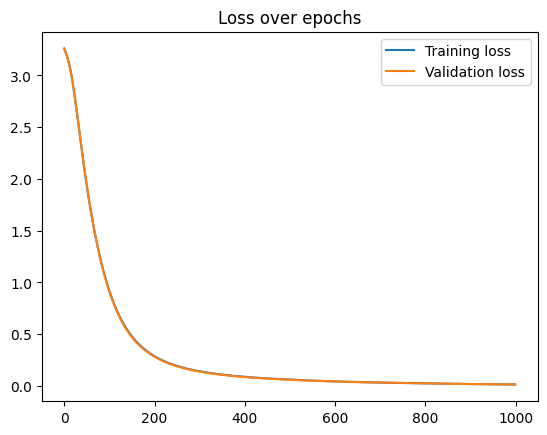

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Save Model to Storage

In [22]:
# Save model for model inference
# Save the model's state_dict
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model.pth') # Save

# Test Finished Trained model

In [26]:
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

In [27]:
probabilities = predict(model, landmarks, DEVICE)
print(probabilities)

[8.5095531e-17 6.0681018e-08 6.0164677e-13 ... 3.5524443e-14 9.9994671e-01
 6.5132207e-07]


In [28]:
print(len(probabilities))

3666


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\envs\Vision_AI_Env\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\anaconda3\envs\Vision_AI_Env\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\envs\Vision_AI_Env\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\anaconda3\envs\Vision_AI_Env\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    dat